# Histological Features Analysis

In this notebook, I focus on the analysis of histological features extracted from tissue images, integrated with spatial and transcriptomic data.  
The main questions are:

- Are the Unknown cells more similar to Malignant or Normal cells?
- Are histological data and molecular data complementary? 
- Why do the cells reclassified as Unknown ⟶ Malignant have both signatures lower?
- Are there molecular markers for the histological subclusters?

The goal is to assess whether histological features, such as combinations of texture, cellular organization, and microenvironment structure, can improve cell classification and whether they provide complementary insights to those obtained from molecular features.


## Library Imports
This section imports the libraries required for the analysis:

In [95]:
# System & OS utilities
import os
os.makedirs('results/DGE', exist_ok=True)
os.makedirs('figures/DGE_rank_genes', exist_ok=True)
os.makedirs('figures/DGE_dotplot', exist_ok=True)

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Single-cell & spatial data
import scanpy as sc
import spatialdata as sd
import cellcharter as cc

# Machine learning & stats
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, accuracy_score, cohen_kappa_score, classification_report, confusion_matrix)

## Dataset Loading

In this section, the datasets used for the analysis are loaded:

- **Xenium_V1_FFPE_Human_Breast_IDC.zarr** (referred to as *xenium*): the full spatial transcriptomics dataset.  
- **epithelial_cells**: a subset of *xenium* containing only epithelial cells, on which the downstream analyses are focused.  
- **molecular_single_features**: features derived from gene expression measurements in each epithelial cell, representing the molecular profile of the cell.  
- **histological_single_features**: histological features automatically extracted from immagini H&E tramite il modello iBOT ViT-Base.

In [58]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

In [59]:
epithelial_cells = sc.read_h5ad("epithelial_cells_cell_type_prediction_filtered.h5ad")

In [60]:
molecular_single_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_molecular_epithelial.csv")

In [61]:
histological_single_features = pd.read_csv("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_histology_epithelial.csv")

## Adding Features

Molecular and histological features are added to their respective `AnnData` objects in the `.obsm` attribute to facilitate their use in clustering and visualization analyses.

In [62]:
def create_feature_anndata(epithelial_cells, feature_df, obsm_key):
    # If 'cell_id' is a column, use it as the index
    if "cell_id" in feature_df.columns:
        feature_df = feature_df.set_index("cell_id")

    # Convert to string to align
    obs_ids = epithelial_cells.obs['cell_id'].astype(str)
    feature_df.index = feature_df.index.astype(str)

    # Find common cells
    common_cells = obs_ids[obs_ids.isin(feature_df.index)]
    adata_filtered = epithelial_cells[common_cells.index].copy()

    # Align features in the correct order
    feature_aligned = feature_df.loc[common_cells]

    # Insert features
    adata_filtered.obsm[obsm_key] = feature_aligned.astype("float32").to_numpy()
    adata_filtered.uns[obsm_key + "_feature_names"] = feature_aligned.columns.tolist()

    print(f"Features added to `{obsm_key}`. {adata_filtered.n_obs} cells, {feature_aligned.shape[1]} features.")
    return adata_filtered

# SINGLE FEATURES = XENIUM-SPECIFIC FEATURES ONLY FOR EPITHELIAL CELLS
adata_molecular_single_features = create_feature_anndata(epithelial_cells, molecular_single_features, "molecular_single_features")
adata_histological_single_features = create_feature_anndata(epithelial_cells, histological_single_features, "histological_single_features")

Features added to `molecular_single_features`. 348692 cells, 10 features.
Features added to `histological_single_features`. 348692 cells, 10 features.


## Downsampling

To ensure comparability across cell types, I downsample each group to the same number of cells (25,000 Malignant, 25,000 Normal, and all Unknown cells), using a fixed seed (42) for reproducibility. This step is important because GMM clustering is sensitive to imbalanced datasets.

In [63]:
def downsample_adata(adata, label_key="cell_type_prediction", n_per_class=25000, seed=42):
    rng = np.random.default_rng(seed)  # inizializzo il generatore con seed
    idxs = []
    for cat in adata.obs[label_key].unique():
        cat_idx = np.where(adata.obs[label_key] == cat)[0]
        if len(cat_idx) > n_per_class:
            chosen = rng.choice(cat_idx, n_per_class, replace=False)  
        else:
            chosen = cat_idx
        idxs.extend(chosen)
    
    return adata[idxs].copy()

adata_molecular_single_features_down = downsample_adata(adata_molecular_single_features, n_per_class=25000, seed=42)
adata_histological_single_features_down = downsample_adata(adata_histological_single_features, n_per_class=25000, seed=42)

## Unsupervised Clustering with ClusterAutoK

The `ClusterAutoK` method is applied to automatically identify the optimal number of clusters, using both scaled and unscaled features.  
The analyses are performed separately for:  
- **Molecular features** (`molecular_single_features`)  
- **Histological features** (`histological_single_features`)  

For each analysis, a cluster stability plot is generated to support the selection of the most robust number of clusters. The fitted model is then saved for downstream analyses. ClusterAutoK is an unsupervised clustering method, meaning it does not use pre-assigned labels. It selects the optimal number of clusters based on internal metrics of cluster quality and stability, making it suitable for exploring structure in high-dimensional molecular or histological data.

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

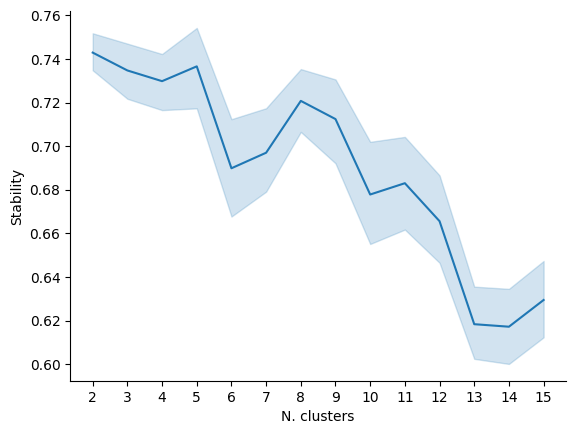

In [747]:
# ClusterAutoK on UNSCALED MOLECULAR SINGLE FEATURES DOWN k=5

autok_molecular_single_features_unscaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15), 
    max_runs=10,
    convergence_tol=0.001)

autok_molecular_single_features_unscaled.fit(
    adata_molecular_single_features_down, 
    use_rep='molecular_single_features')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_molecular_single_features_unscaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "molecular_single_features_unscaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/molecular_single_features_unscaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_molecular_single_features_unscaled.save(save_path, best_k=False)

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

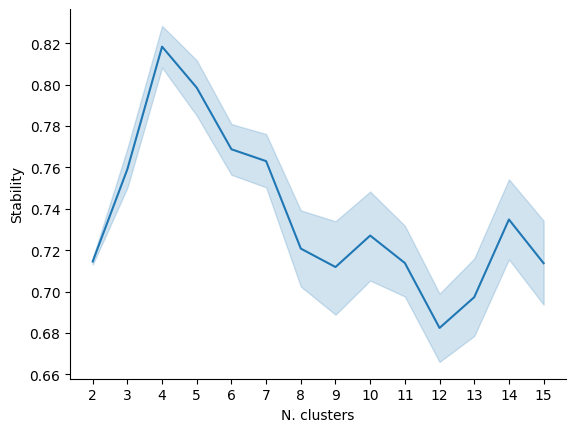

In [741]:
# ClusterAutoK on UNSCALED HISTOLOGICAL SINGLE FEATURES DOWN k=4

autok_histological_single_features_unscaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_histological_single_features_unscaled.fit(
    adata_histological_single_features_down,
    use_rep='histological_single_features')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_histological_single_features_unscaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "histological_single_features_unscaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/histological_single_features_unscaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_histological_single_features_unscaled.save(save_path, best_k=False)

## Feature Standardization

Features are scaled using `StandardScaler` to normalize the variance across variables. This step is crucial to prevent features with different ranges from disproportionately influencing the clustering. The scaled data are saved in new .obsm matrices, preserving the original unscaled versions for comparison.

In [64]:
def standardize_features(adata, obsm_key, new_obsm_key):
    scaler = StandardScaler()
    X = adata.obsm[obsm_key]
    X_scaled = scaler.fit_transform(X)
    adata.obsm[new_obsm_key] = X_scaled
    return adata

adata_molecular_single_features_down = standardize_features(
    adata_molecular_single_features_down,
    obsm_key="molecular_single_features",
    new_obsm_key="molecular_single_features_scaled")

adata_histological_single_features_down = standardize_features(
    adata_histological_single_features_down,
    obsm_key="histological_single_features",
    new_obsm_key="histological_single_features_scaled")

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

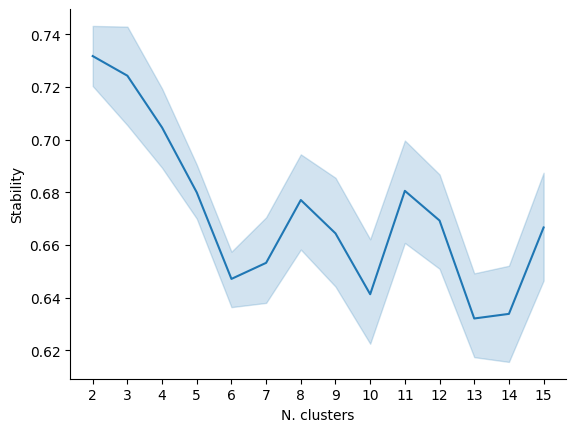

In [748]:
# ClusterAutoK on SCALED MOLECULAR SINGLE FEATURES DOWN k=2

autok_molecular_single_features_scaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_molecular_single_features_scaled.fit(
    adata_molecular_single_features_down, 
    use_rep='molecular_single_features_scaled')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_molecular_single_features_scaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "molecular_single_features_scaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/molecular_single_features_scaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_molecular_single_features_scaled.save(save_path, best_k=False)

Iteration 1/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 8/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 9/10


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 10/10


  0%|          | 0/16 [00:00<?, ?it/s]

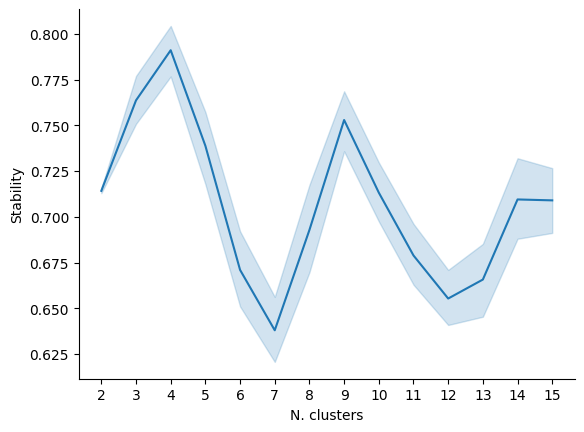

In [743]:
# ClusterAutoK on SCALED HISTOLOGICAL SINGLE FEATURES k=4

autok_histological_single_features_scaled = cc.tl.ClusterAutoK(
    n_clusters=(2,15),
    max_runs=10,
    convergence_tol=0.001)

autok_histological_single_features_scaled.fit(
    adata_histological_single_features_down,
    use_rep='histological_single_features_scaled')

# Visualize cluster stability
ax = cc.pl.autok_stability(autok_histological_single_features_scaled, return_ax=True)
fig = ax.get_figure()
fig.savefig(images_path / "histological_single_features_scaled_autok_plot.pdf", dpi=300)

# Save the model
save_path = Path("saved_models_final/histological_single_features_scaled_autok")
save_path.mkdir(parents=True, exist_ok=True)
autok_histological_single_features_scaled.save(save_path, best_k=False)

## Loading Models and Predicting Clusters

Saved `ClusterAutoK` models are reloaded to assign final clusters to the AnnData objects. The assignments include:
Le assegnazioni includono:
- `cluster_5_unscaled` for unscaled molecular features
- `cluster_2_scaled` or scaled molecular features
- `cluster_4_unscaled` and `cluster_4_scaled` for histological features

These cluster assignments will be used to assess consistency across different domains (molecular vs. histological).

In [65]:
# MOLECULAR_SINGLE_FEATURES_DOWN_UNSCALED k=5     
autok_molecular_single_features_down_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_single_features_unscaled_autok")
adata_molecular_single_features_down.obs['cluster_5_unscaled'] = autok_molecular_single_features_down_unscaled_loaded.predict(
    adata_molecular_single_features_down, use_rep='molecular_single_features', k=5)

# MOLECULAR_SINGLE_FEATURES_DOWN_SCALED k=2    
autok_molecular_single_features_down_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/molecular_single_features_scaled_autok")
adata_molecular_single_features_down.obs['cluster_2_scaled'] = autok_molecular_single_features_down_scaled_loaded.predict(
    adata_molecular_single_features_down, use_rep='molecular_single_features_scaled', k=2)


# HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED k=4   
autok_histological_single_features_down_unscaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/histological_single_features_unscaled_autok")
adata_histological_single_features_down.obs['cluster_4_unscaled'] = autok_histological_single_features_down_unscaled_loaded.predict(
    adata_histological_single_features_down, use_rep='histological_single_features', k=4)

# HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED k=4   
autok_histological_single_features_down_scaled_loaded = cc.tl.ClusterAutoK.load("saved_models_final/histological_single_features_scaled_autok")
adata_histological_single_features_down.obs['cluster_4_scaled'] = autok_histological_single_features_down_scaled_loaded.predict(
    adata_histological_single_features_down, use_rep='histological_single_features_scaled', k=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [66]:
dataset_configs = {
    'HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED': {
        'adata': adata_histological_single_features_down,
        'n_comp': '4_scaled',
        'malignant_clusters': [0, 3],
        'normal_clusters': [1, 2]
    },
    'MOLECULAR_SINGLE_FEATURES_DOWN_SCALED': {
        'adata': adata_molecular_single_features_down,
        'n_comp': '2_scaled',
        'malignant_clusters': [1],
        'normal_clusters': [0]
    },
    'HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED': {
        'adata': adata_histological_single_features_down,
        'n_comp': '4_unscaled',
        'malignant_clusters': [1, 2],
        'normal_clusters': [0, 3]
    },
    'MOLECULAR_SINGLE_FEATURES_DOWN_UNSCALED': {
        'adata': adata_molecular_single_features_down,
        'n_comp': '5_unscaled',
        'malignant_clusters': [0, 1, 4],
        'normal_clusters': [2, 3]
    }
}

## Cluster Reassignment Pipeline and Analysis of Unknown Groups
This section outlines the pipeline used to analyze clusters and reclassify Unknown cell groups. The main steps include:
- Compute global cell type percentages
- Calculate fold-changes for each cluster
- Visualize fold-changes using heatmaps
- Assign labels to clusters
- Reclassify Unknown cell groups
- Plot molecular signature distributions by group
- Assess cluster composition in percentages
- Analyze `total_counts` in Unknown groups

In [67]:
def full_pipeline(adata, malignant_clusters, normal_clusters, output_prefix="dataset"):
    # CUSTOM PALETTE 
    custom_palette = {
        'Unknown → Malignant': '#D94F4F',
        'Unknown → Normal': '#009E73',
        'Unknown (unchanged)': '#56B4E9',
        'Malignant (original)': '#D94F4F',
        'Normal (original)': '#009E73'}

    def plot_counts_with_means(df, x_var, y_var='total_counts', order=None,
                               title='', palette='Set2', figsize=(7,5), save_path=None):
        plt.figure(figsize=figsize)
        ax = sns.boxplot(
            data=df,
            x=x_var,
            y=y_var,
            palette=palette if isinstance(palette, str) else [palette.get(cat, 'gray') for cat in order],
            order=order,
            showfliers=False)
        sns.stripplot(
            data=df,
            x=x_var,
            y=y_var,
            color='black',
            alpha=0.3,
            jitter=True,
            order=order,
            ax=ax)

        means = df.groupby(x_var)[y_var].mean()
        y_range = df[y_var].max() - df[y_var].min()

        for i, cat in enumerate(order):
            if cat in means.index:
                mean_val = means[cat]
                ax.hlines(mean_val, i - 0.35, i + 0.35, colors='black', linewidth=3)
                bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
                ax.text(i, mean_val + 0.07 * y_range, f"{mean_val:.1f}",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        color='black', bbox=bbox_props)

        plt.title(title)
        plt.xticks(rotation=45)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()
        plt.close()

    # INITIAL SETUP 
    cluster_col = "cluster"
    new_cluster_col = "new_cluster"
    reclassified_col = "reclassified_cluster"

    os.makedirs("figures", exist_ok=True)
    os.makedirs("results", exist_ok=True)

    # GLOBAL PERCENTAGES 
    cell_type_counts = adata.obs['cell_type_prediction'].value_counts()
    total_cells = cell_type_counts.sum()
    malignant_pct_total = (cell_type_counts.get('Malignant', 0) / total_cells) * 100
    normal_pct_total = (cell_type_counts.get('Normal', 0) / total_cells) * 100
    unknown_pct_total = (cell_type_counts.get('Unknown', 0) / total_cells) * 100

    # FOLD CHANGE PER CLUSTER 
    cluster_counts = adata.obs.groupby([cluster_col, "cell_type_prediction"]).size().unstack(fill_value=0)
    cluster_counts["Total"] = cluster_counts.sum(axis=1)
    for ctype in ['Malignant', 'Normal', 'Unknown']:
        cluster_counts[f"{ctype} %"] = cluster_counts[ctype] / cluster_counts["Total"] * 100
        cluster_counts[f"Fold change % {ctype}"] = cluster_counts[f"{ctype} %"] / eval(f"{ctype.lower()}_pct_total")

    # HEATMAP 
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_counts[[f"Fold change % Malignant", f"Fold change % Normal", f"Fold change % Unknown"]],
                cmap="viridis", annot=True, fmt=".1f")
    plt.title("Fold-change of Cell Types")
    plt.tight_layout()
    plt.savefig(f"figures/HEATMAP_{cluster_col}.pdf", dpi=300)
    plt.show()
    plt.close()

    # ASSIGN CLUSTER LABELS 
    def assign_cluster_label(cluster):
        if cluster in malignant_clusters:
            return "Malignant"
        elif cluster in normal_clusters:
            return "Normal"
        else:
            return "Unknown"

    adata.obs[new_cluster_col] = adata.obs[cluster_col].apply(assign_cluster_label)

    # RECLASSIFICATION 
    def classify_group(row):
        original = row['cell_type_prediction']
        new = row[new_cluster_col]
        if original == 'Malignant':
            return 'Malignant (original)'
        elif original == 'Normal':
            return 'Normal (original)'
        elif original == 'Unknown':
            if new == 'Malignant':
                return 'Unknown → Malignant'
            elif new == 'Normal':
                return 'Unknown → Normal'
            else:
                return 'Unknown (unchanged)'
        else:
            return 'Other'

    adata.obs[reclassified_col] = adata.obs.apply(classify_group, axis=1)

    # BOXPLOT SIGNATURES BY GROUP 
    for signature in ['malignant_signature', 'normal_signature']:
        order = ['Malignant (original)', 'Unknown → Malignant', 'Unknown (unchanged)',
                 'Unknown → Normal', 'Normal (original)']
        order = [o for o in order if o in adata.obs[reclassified_col].unique()]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=adata.obs, x=reclassified_col, y=signature, order=order)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.title(f'{signature} by group')
        plt.savefig(f'figures/{output_prefix}_{signature}_boxplot.pdf', dpi=300)
        plt.show()
        plt.close()

    # CLUSTER COMPOSITION 
    cluster_dist = pd.crosstab(adata.obs[cluster_col], adata.obs['cell_type_prediction'])
    cluster_pct = cluster_dist.div(cluster_dist.sum(axis=1), axis=0) * 100
    palette_comp = {'Malignant': '#D94F4F', 'Unknown': '#5A9BD5', 'Normal': '#009E73'}
    ax = cluster_pct.plot(kind='bar', stacked=True, figsize=(12, 6),
                          color=[palette_comp.get(ct, 'gray') for ct in cluster_pct.columns])
    for i, cluster in enumerate(cluster_pct.index):
        y_offset = 0
        for cell_type in cluster_pct.columns:
            pct = cluster_pct.loc[cluster, cell_type]
            if pct > 3:
                ax.text(i, y_offset + pct / 2, f'{pct:.1f}%', ha='center', va='center',
                        fontsize=9, color='black', fontweight='bold')
            y_offset += pct
    plt.ylabel('Percentage of Cells')
    plt.title('Cell Type Composition per Cluster')
    plt.tight_layout()
    plt.savefig(f'figures/{output_prefix}_cluster_composition.pdf', dpi=300)
    plt.show()
    plt.close()

    # BOXPLOT TOTAL_COUNTS IN UNKNOWN GROUPS 
    df_unknown = adata.obs[adata.obs['cell_type_prediction'] == 'Unknown'].copy()
    plot_order = ['Unknown → Malignant', 'Unknown (unchanged)', 'Unknown → Normal']
    df_plot = df_unknown[df_unknown[reclassified_col].isin(plot_order)].copy()
    present_groups = [g for g in plot_order if g in df_plot[reclassified_col].unique()]
    if present_groups:
        df_plot[reclassified_col] = pd.Categorical(df_plot[reclassified_col], categories=present_groups, ordered=True)
        plot_counts_with_means(
            df_plot,
            x_var=reclassified_col,
            y_var='total_counts',
            order=present_groups,
            title='Total Counts per Unknown Group',
            palette=custom_palette,
            figsize=(7, 5),
            save_path=f'figures/{output_prefix}_unknown_total_counts.pdf')
    return adata


Running pipeline for: HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED


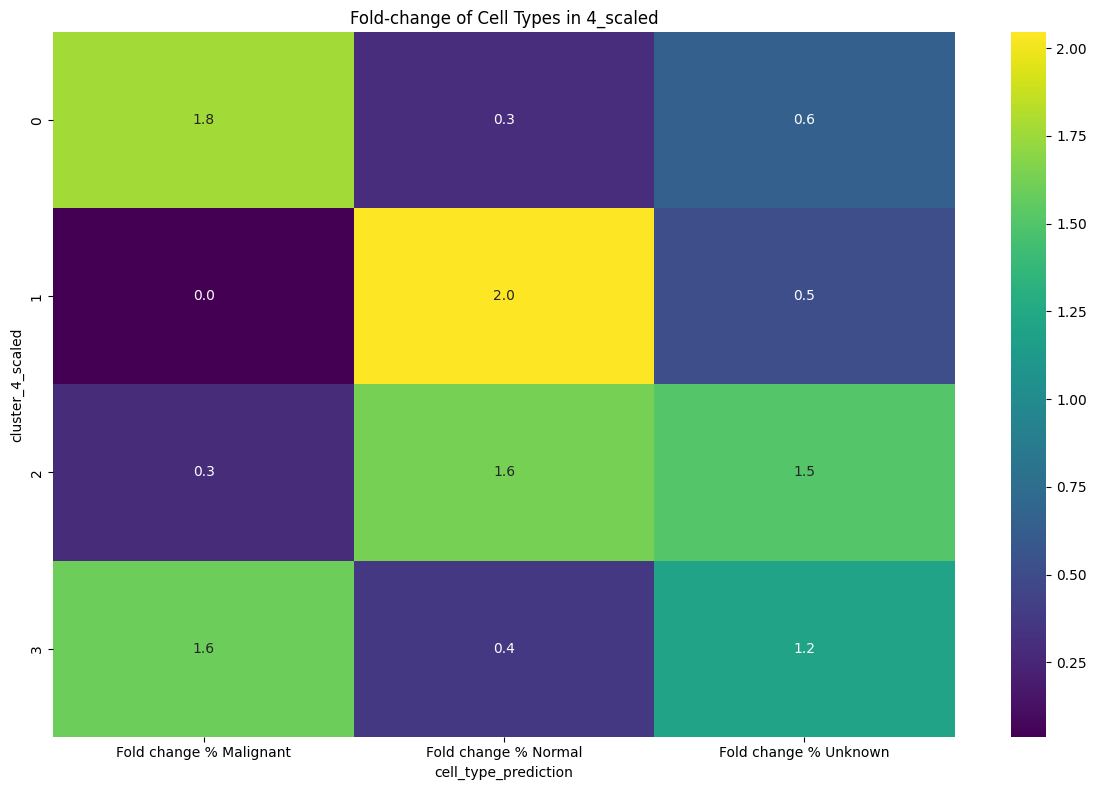

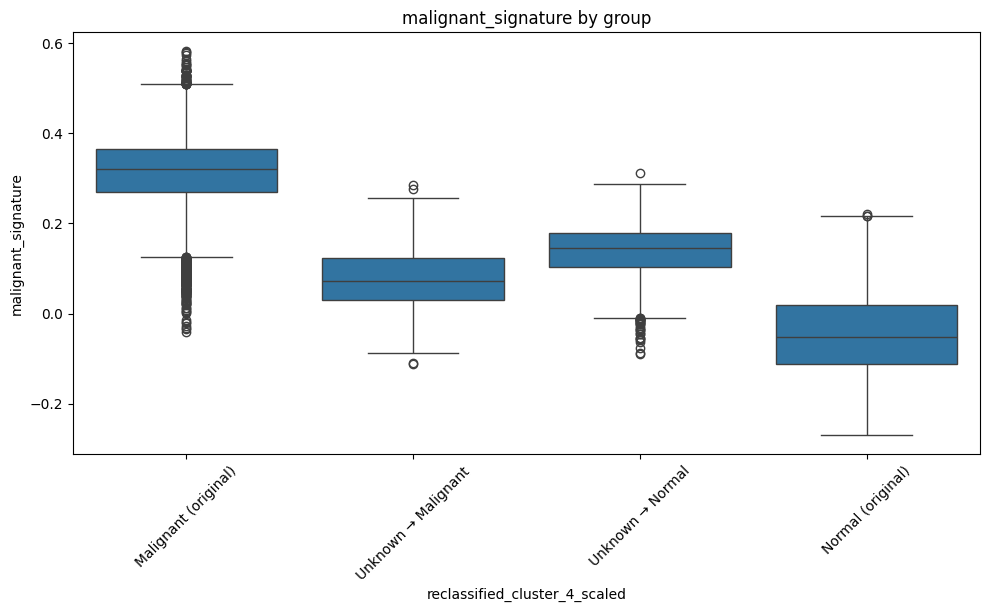

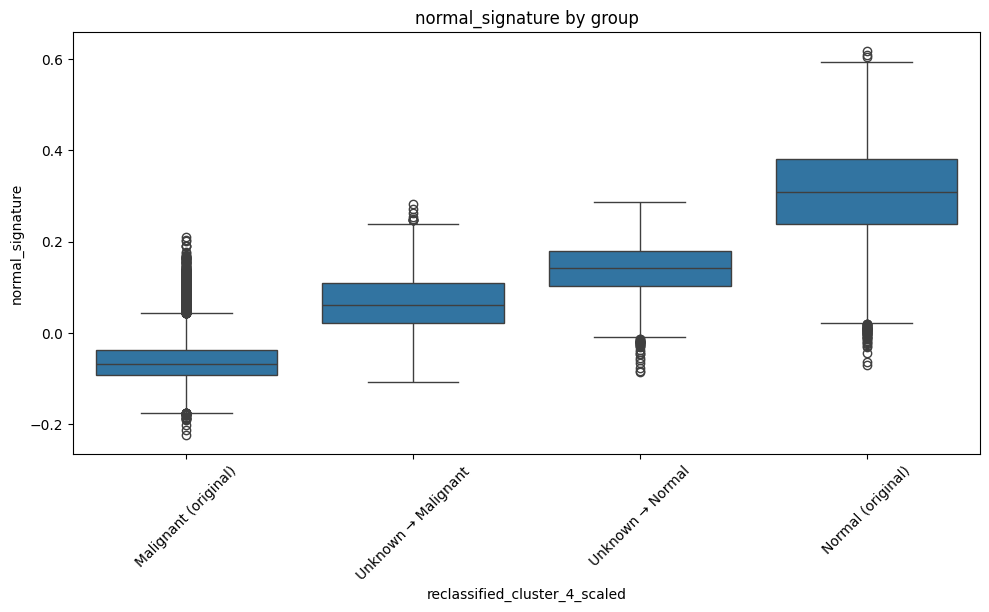

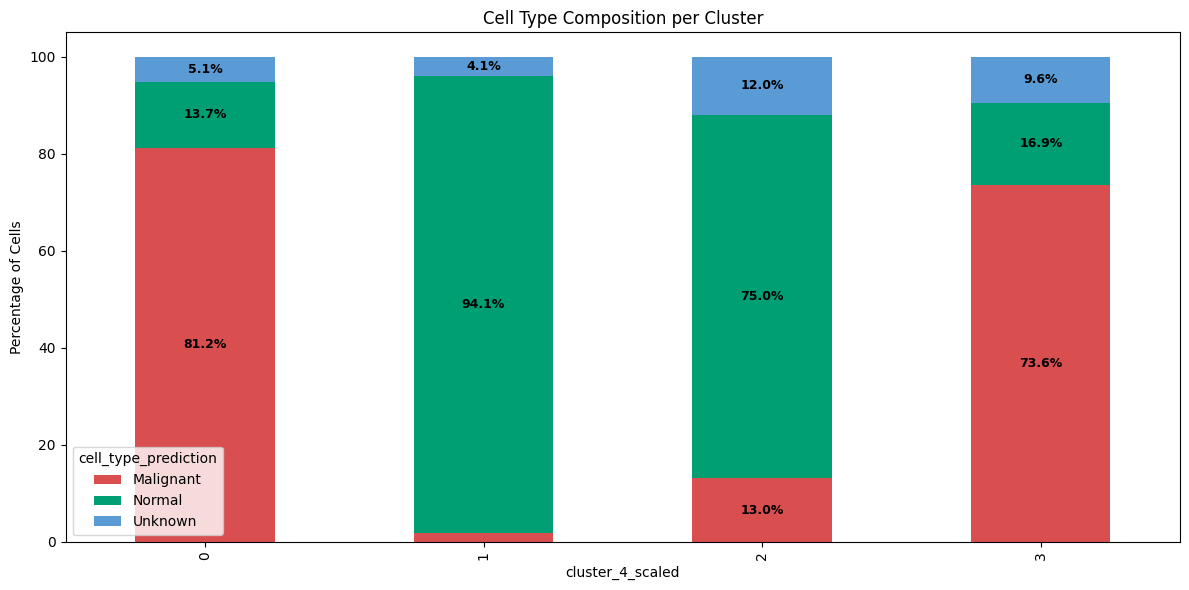

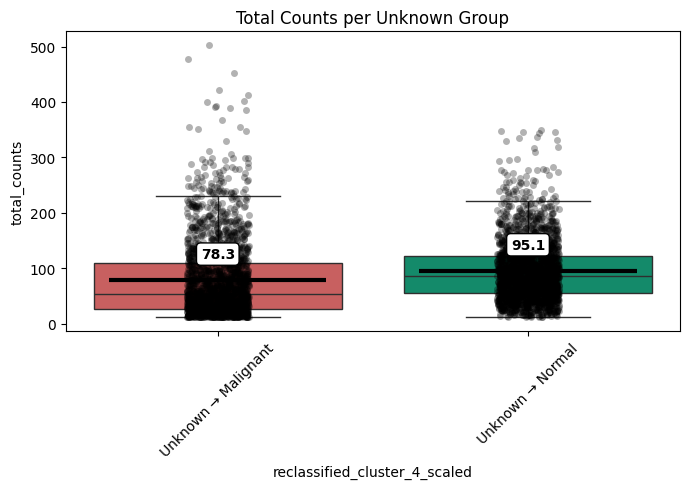


Running pipeline for: MOLECULAR_SINGLE_FEATURES_DOWN_SCALED


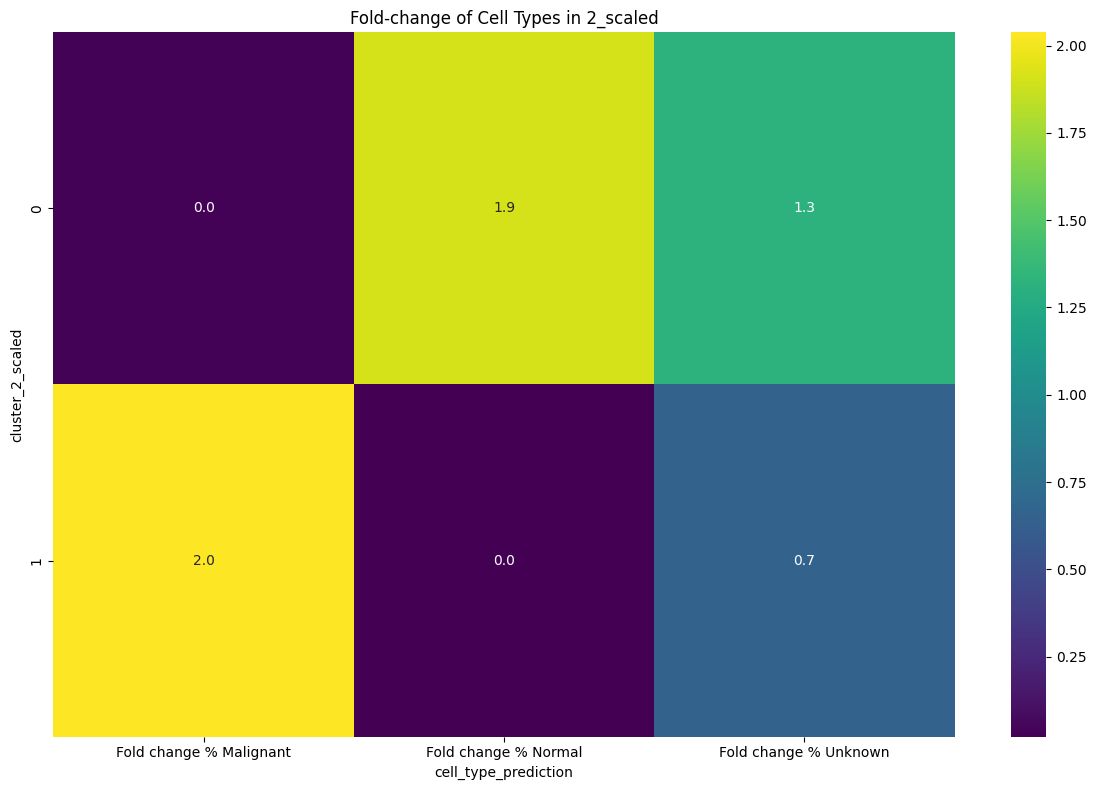

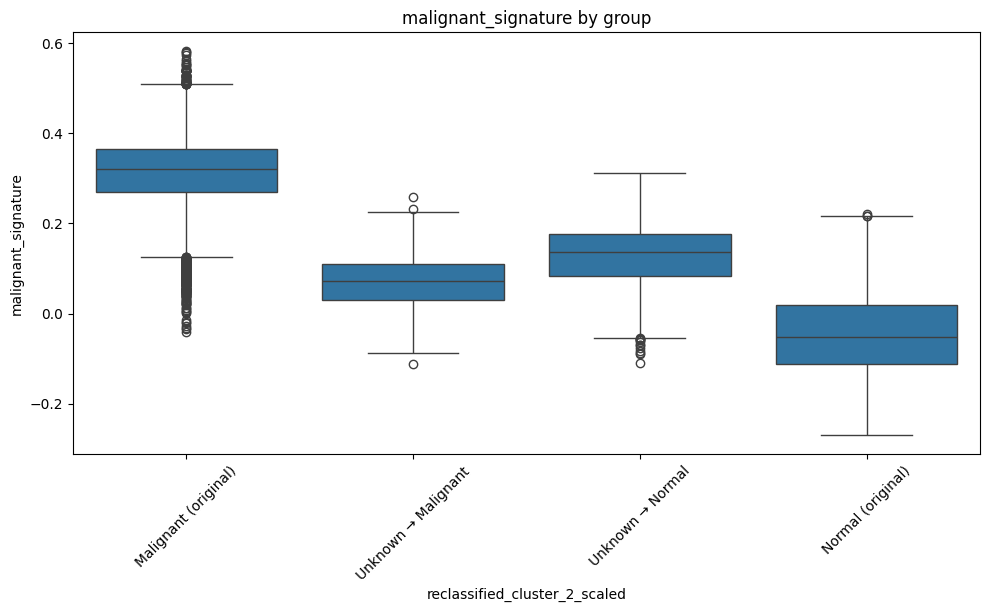

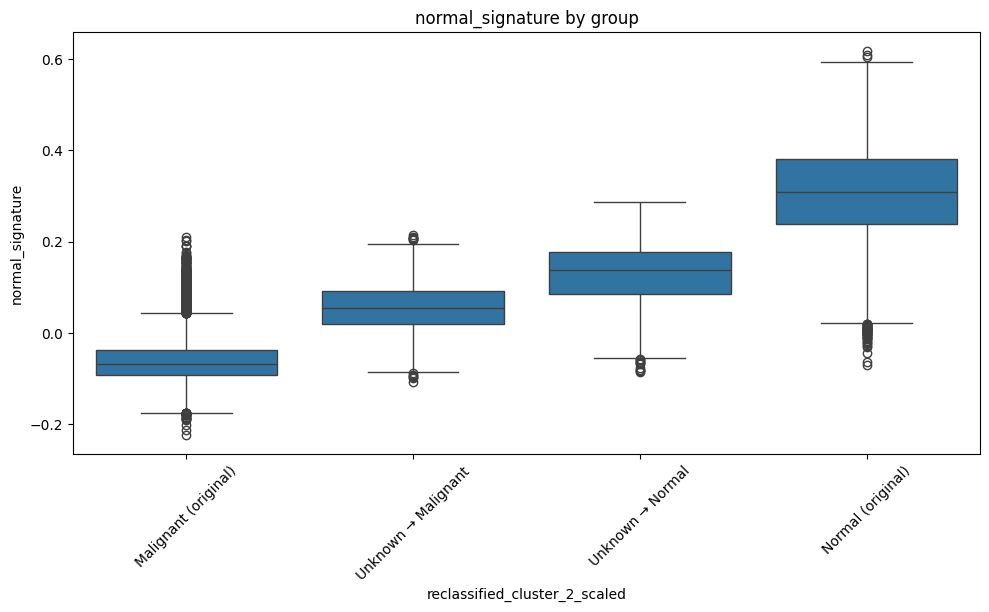

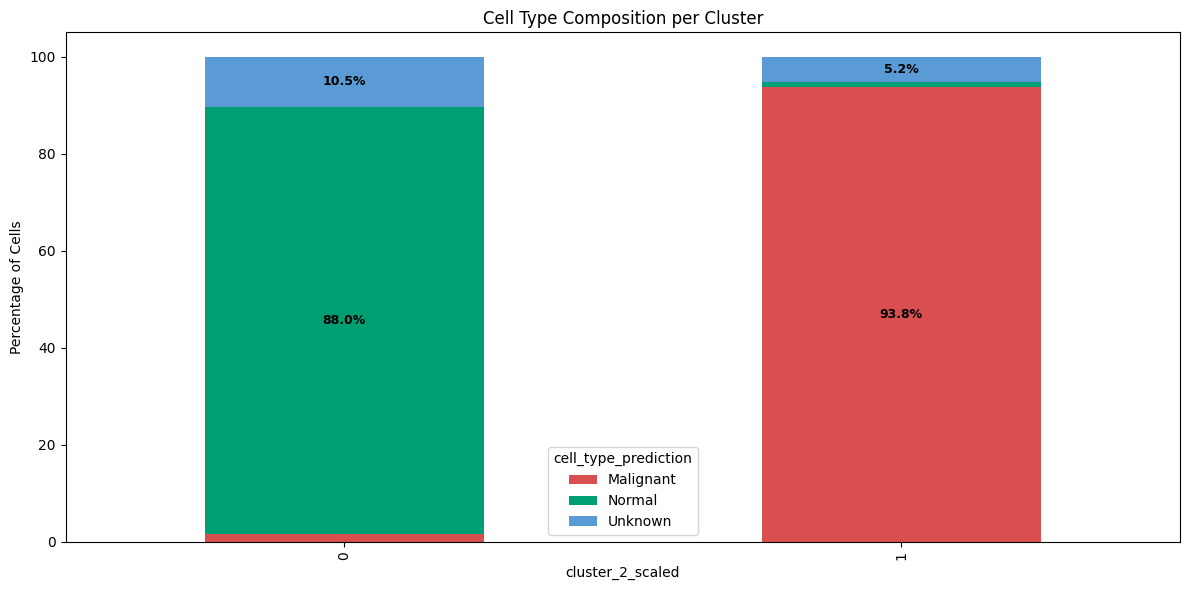

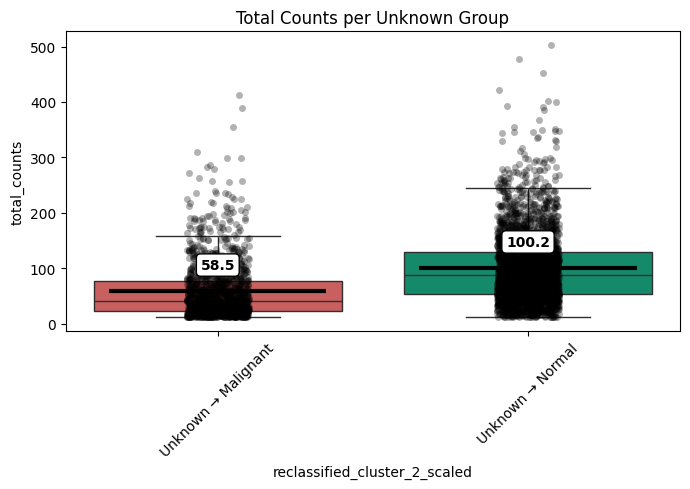


Running pipeline for: HISTOLOGICAL_SINGLE_FEATURES_DOWN_UNSCALED


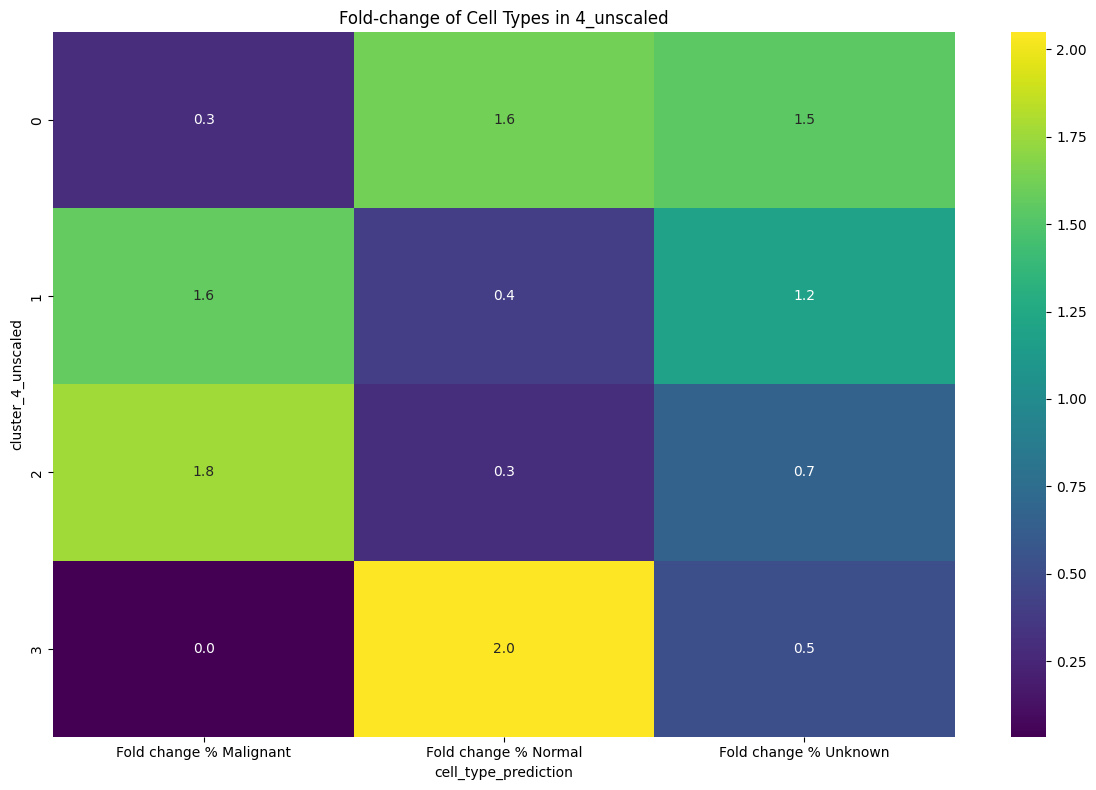

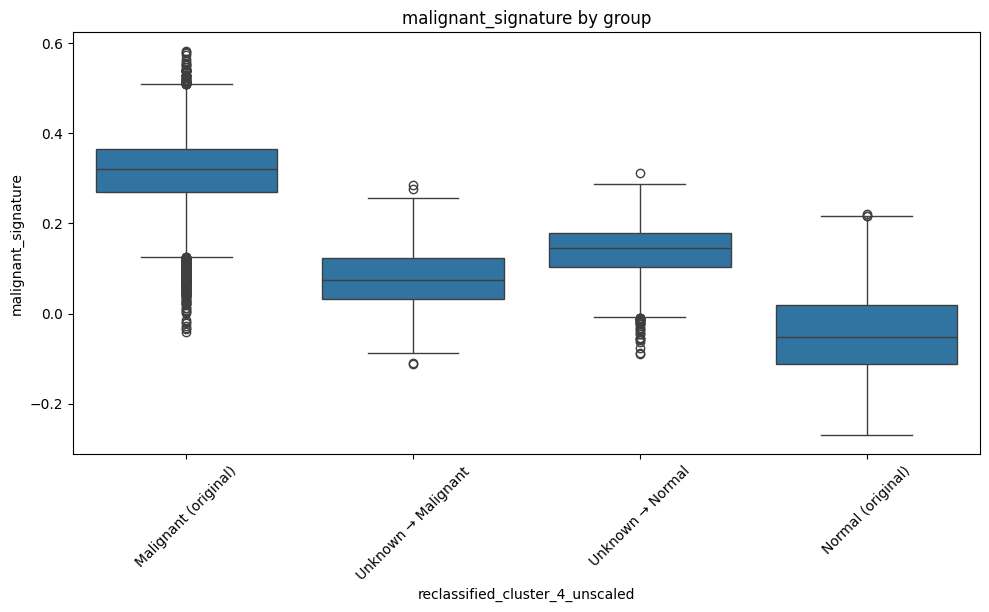

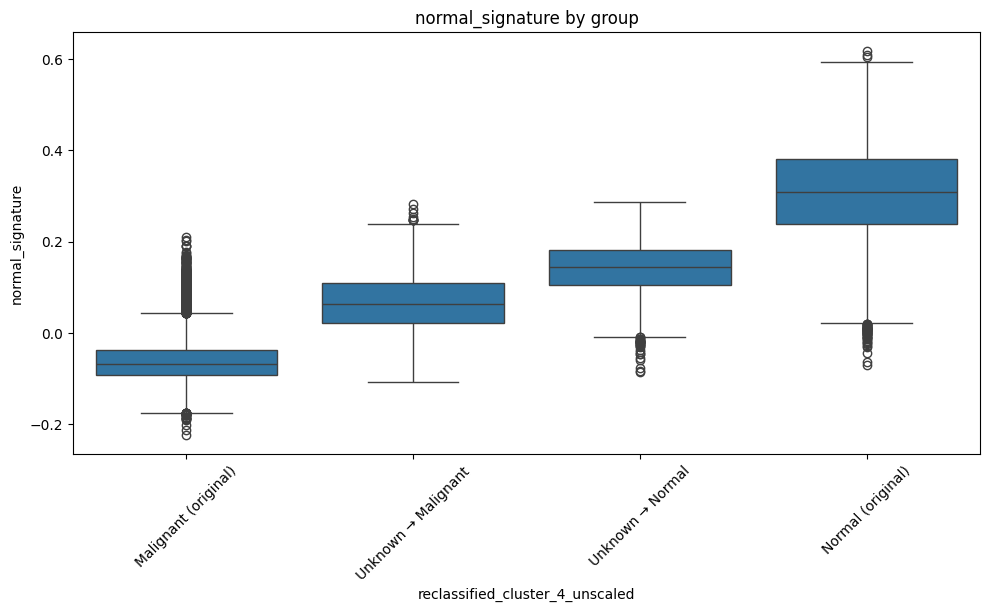

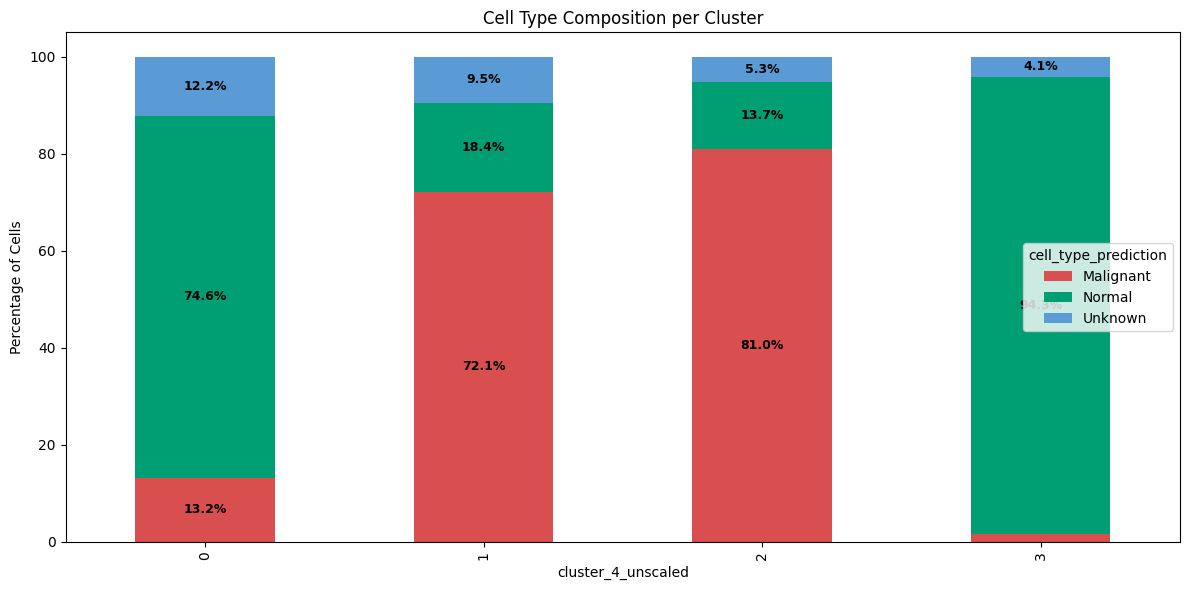

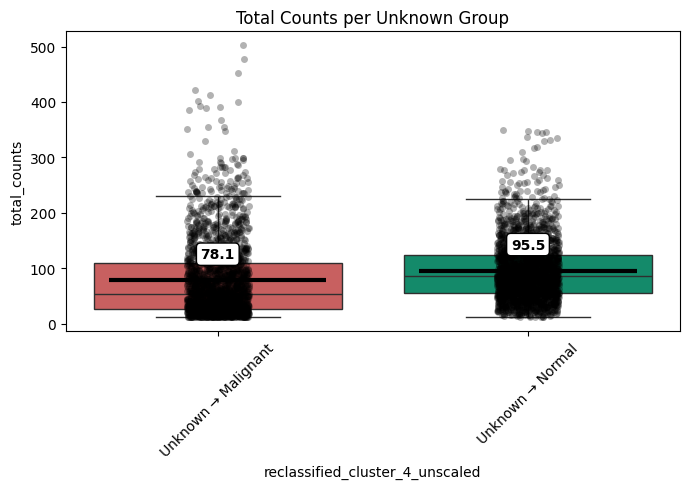


Running pipeline for: MOLECULAR_SINGLE_FEATURES_DOWN_UNSCALED


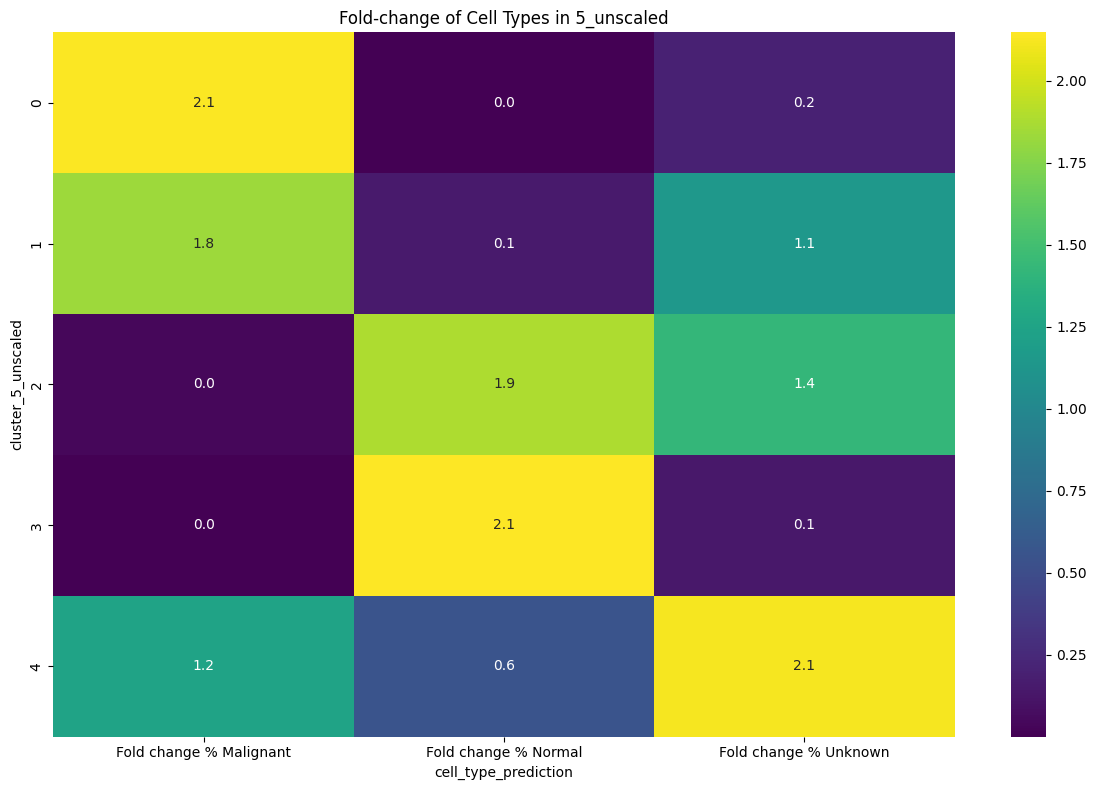

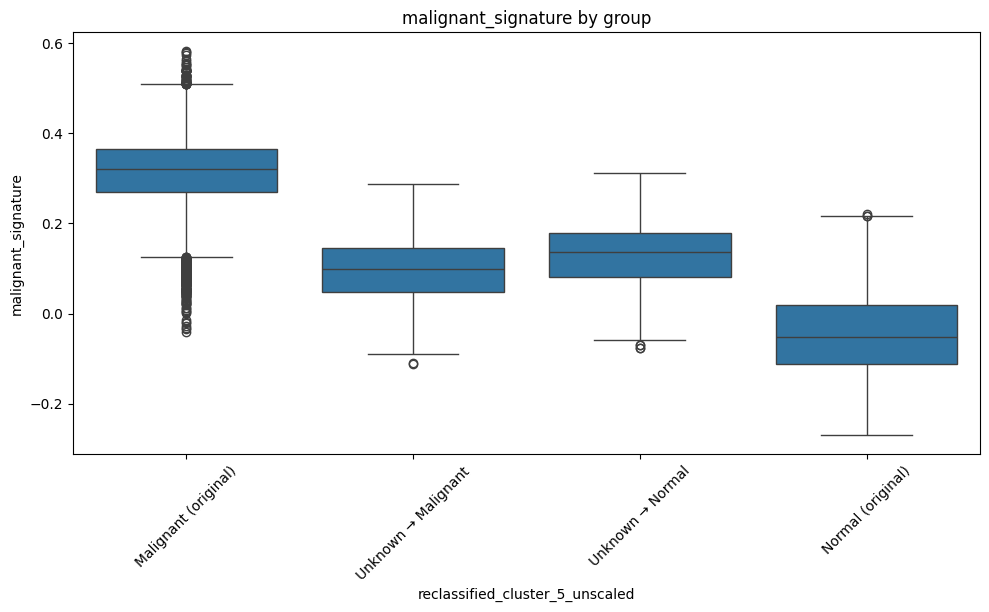

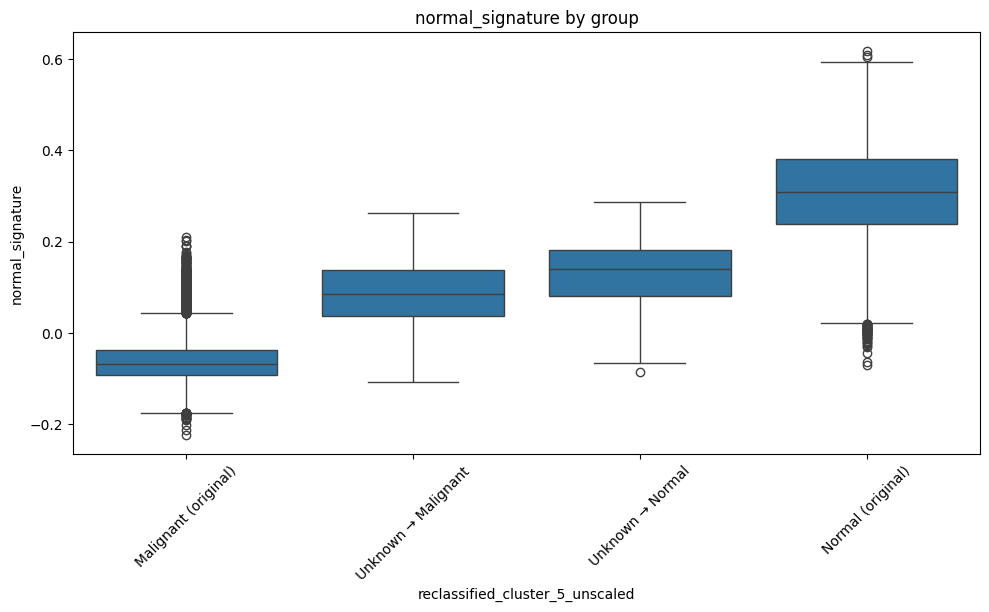

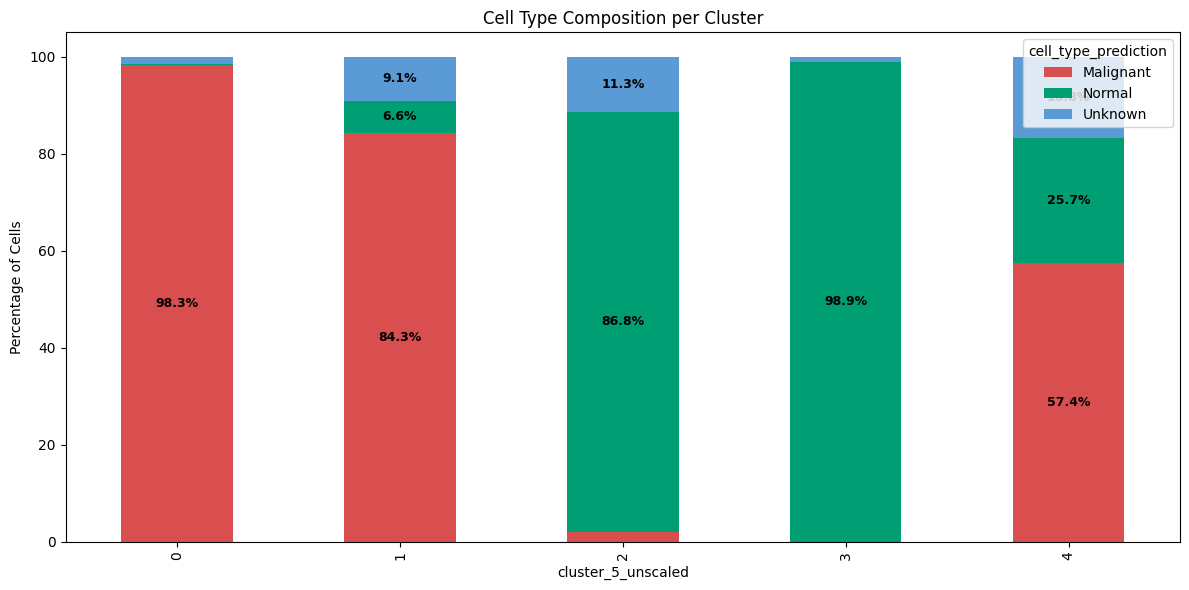

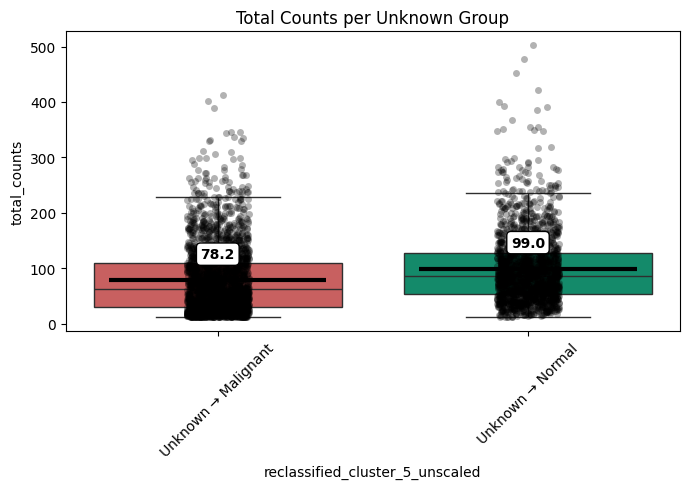

In [68]:
for name, config in dataset_configs.items():
    print(f"\nRunning pipeline for: {name}")
    adata_result = full_pipeline(
        adata=config['adata'],
        n_comp=config['n_comp'],
        malignant_clusters=config['malignant_clusters'],
        normal_clusters=config['normal_clusters'],
        output_prefix=name)

## Stratified Sampling for Comparing Unknown→Malignant vs Unknown→Normal
To fairly compare the molecular signatures of the two Unknown groups, stratified sampling is performed based on `total_counts`.

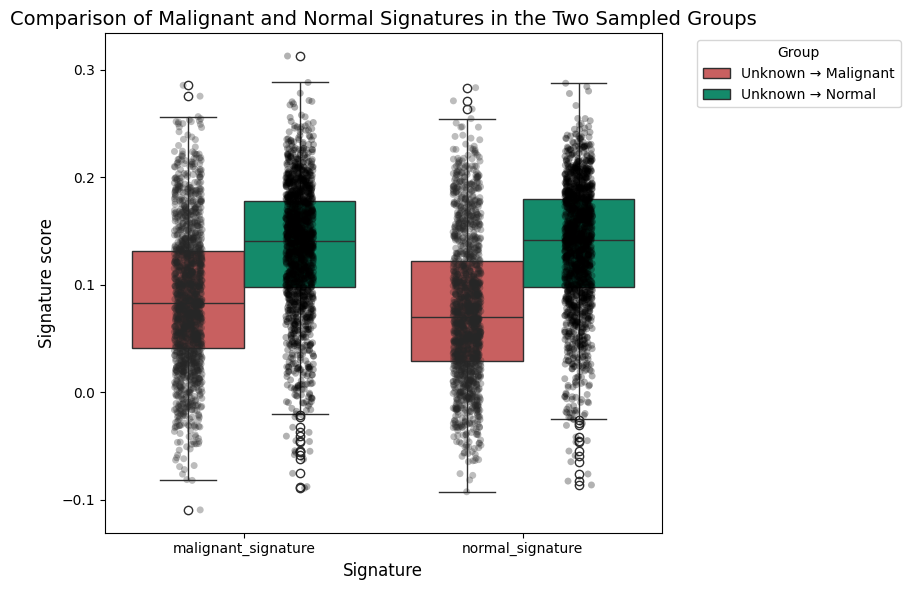


Final proportional distribution by bin - Unknown → Malignant:
count_bin
(10.998000000000001, 12.0]    0.004073
(12.0, 12.2]                  0.000000
(12.2, 13.0]                  0.000679
(13.0, 14.0]                  0.004073
(14.0, 15.0]                  0.004752
                                ...   
(263.167, 275.6]              0.004073
(275.6, 287.9]                0.004073
(287.9, 309.8]                0.002716
(309.8, 350.633]              0.002037
(350.633, 503.0]              0.000000
Name: proportion, Length: 183, dtype: float64

Final proportional distribution by bin - Unknown → Normal:
count_bin
(10.998000000000001, 12.0]    0.004073
(12.0, 12.2]                  0.000000
(12.2, 13.0]                  0.000679
(13.0, 14.0]                  0.004073
(14.0, 15.0]                  0.004752
                                ...   
(263.167, 275.6]              0.004073
(275.6, 287.9]                0.004073
(287.9, 309.8]                0.002716
(309.8, 350.633]              0

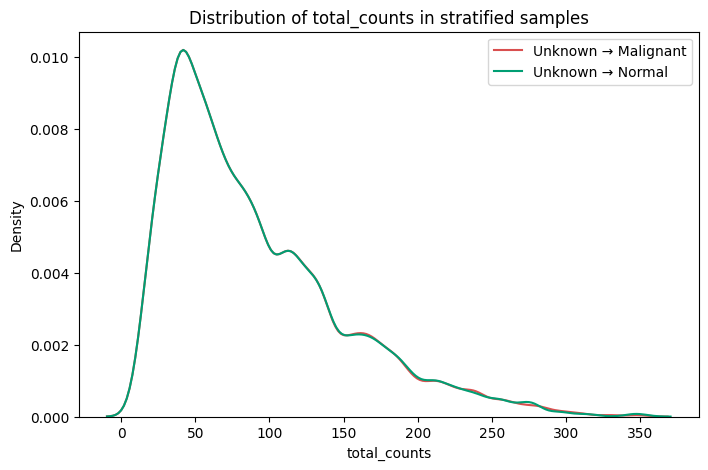

In [69]:
adata = adata_histological_single_features_down
reclassified_col = f'reclassified_cluster_4_scaled'

# Filter cells from the two groups into a single dataframe
df_unknown = adata.obs[adata.obs[reclassified_col].isin(['Unknown → Malignant', 'Unknown → Normal'])].copy()

# Define common bins calculated on the entire dataframe together
n_bins = 300
df_unknown['count_bin'] = pd.qcut(df_unknown['total_counts'], q=n_bins, duplicates='drop')

# Split groups
df_malignant_group = df_unknown[df_unknown[reclassified_col] == 'Unknown → Malignant'].copy()
df_normal_group = df_unknown[df_unknown[reclassified_col] == 'Unknown → Normal'].copy()

def stratified_sample_same_bins_with_print(df_group1, df_group2, n_samples_per_bin=25):
    # Identify bins where both groups have at least one cell
    bins_group1 = set(df_group1['count_bin'].value_counts().index)
    bins_group2 = set(df_group2['count_bin'].value_counts().index)
    common_bins = sorted(list(bins_group1.intersection(bins_group2)))

    samples1 = []
    samples2 = []

    for b in common_bins:
        bin_df1 = df_group1[df_group1['count_bin'] == b]
        bin_df2 = df_group2[df_group2['count_bin'] == b]

        min_count = min(len(bin_df1), len(bin_df2), n_samples_per_bin)
        if min_count == 0:
            continue
        
        samples1.append(bin_df1.sample(n=min_count, random_state=42))
        samples2.append(bin_df2.sample(n=min_count, random_state=42))

    sampled_df1 = pd.concat(samples1).drop(columns='count_bin')
    sampled_df2 = pd.concat(samples2).drop(columns='count_bin')

    return sampled_df1, sampled_df2, common_bins

# Sample cells
sampled_malignant, sampled_normal, common_bins = stratified_sample_same_bins_with_print(
    df_malignant_group, df_normal_group, n_samples_per_bin=25)

# Extract sampled indices
cells_malignant = sampled_malignant.index.tolist()
cells_normal = sampled_normal.index.tolist()

# Prepare dataframe for signature comparison
df_malignant = adata.obs.loc[cells_malignant, ['malignant_signature', 'normal_signature']].copy()
df_malignant['group'] = 'Unknown → Malignant'

df_normal = adata.obs.loc[cells_normal, ['malignant_signature', 'normal_signature']].copy()
df_normal['group'] = 'Unknown → Normal'

df_compare = pd.concat([df_malignant, df_normal])
df_long = df_compare.melt(id_vars='group', var_name='signature', value_name='score')

# Custom color palette
custom_palette = {
    'Unknown → Malignant': '#D94F4F', 
    'Unknown → Normal': '#009E73'}

plt.figure(figsize=(9, 6))
sns.boxplot(data=df_long, x='signature', y='score', hue='group', palette=custom_palette)
sns.stripplot(data=df_long, x='signature', y='score', hue='group', dodge=True, color='black', alpha=0.3, jitter=True, legend=False)

plt.title("Comparison of Malignant and Normal Signatures in the Two Sampled Groups", fontsize=14)
plt.ylabel("Signature score", fontsize=12)
plt.xlabel("Signature", fontsize=12)
plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Add total_counts to samples
sampled_malignant = sampled_malignant.assign(total_counts=adata.obs.loc[sampled_malignant.index, 'total_counts'])
sampled_normal = sampled_normal.assign(total_counts=adata.obs.loc[sampled_normal.index, 'total_counts'])

# Recreate bins for samples using original intervals
bin_edges = [common_bins[0].left] + [interval.right for interval in common_bins]

sampled_malignant['count_bin'] = pd.cut(sampled_malignant['total_counts'], bins=bin_edges, include_lowest=True)
sampled_normal['count_bin'] = pd.cut(sampled_normal['total_counts'], bins=bin_edges, include_lowest=True)

# Print proportional distribution per bin
print("\nFinal proportional distribution by bin - Unknown → Malignant:")
print(sampled_malignant['count_bin'].value_counts(normalize=True).sort_index())

print("\nFinal proportional distribution by bin - Unknown → Normal:")
print(sampled_normal['count_bin'].value_counts(normalize=True).sort_index())

# KDE plot for total_counts distributions
plt.figure(figsize=(8,5))
sns.kdeplot(sampled_malignant['total_counts'], label='Unknown → Malignant', bw_adjust=0.5, color=custom_palette['Unknown → Malignant'])
sns.kdeplot(sampled_normal['total_counts'], label='Unknown → Normal', bw_adjust=0.5, color=custom_palette['Unknown → Normal'])
plt.title('Distribution of total_counts in stratified samples')
plt.xlabel('total_counts')
plt.ylabel('Density')
plt.legend()
plt.show()

## Differential Gene Expression (DGE) for Histological Clusters

This section performs differential gene expression analysis across the histological clusters using the Wilcoxon method.  

reclassified_cluster_4_scaled
Malignant (original)    25000
Normal (original)       25000
Unknown → Normal         2233
Unknown → Malignant      2078
Name: count, dtype: int64


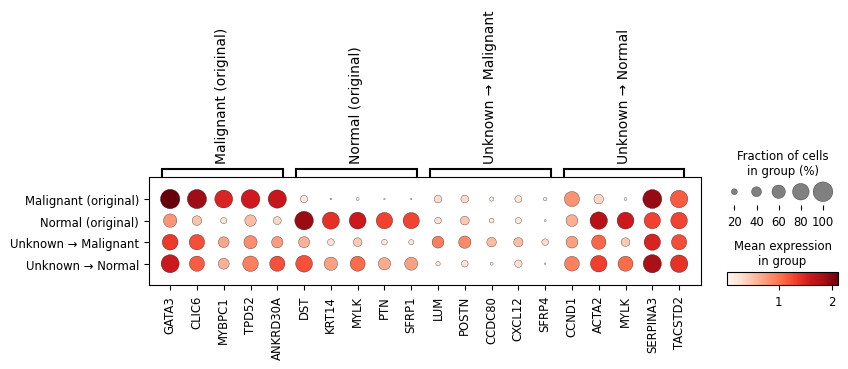

In [70]:
config = dataset_configs['HISTOLOGICAL_SINGLE_FEATURES_DOWN_SCALED']
adata = config['adata']
cluster_col = 'reclassified_cluster_4_scaled'

# Ensure the column exists and convert it to string
adata.obs[cluster_col] = adata.obs[cluster_col].astype(str)

# Check the clusters present
print(adata.obs[cluster_col].value_counts())

# DGE between histological clusters using Wilcoxon method
sc.tl.rank_genes_groups(adata, groupby=cluster_col, method='wilcoxon')

# Plot the top 5 markers per cluster as a dotplot without dendrogram
sc.pl.rank_genes_groups_dotplot(adata, groupby=cluster_col, n_genes=5, dendrogram=False)

# Save the top markers for each cluster to CSV
res = adata.uns['rank_genes_groups']
groups = res['names'].dtype.names
for group in groups:
    df = pd.DataFrame({
        'gene': res['names'][group],
        'logfoldchange': res['logfoldchanges'][group],
        'pval': res['pvals'][group],
        'pval_adj': res['pvals_adj'][group]})
    df.to_csv(f'results/DGE/markers_cluster_{group}.csv', index=False)

## Differential Gene Expression (DGE) Analysis

In this section, I perform differential gene expression (DGE) analysis to compare the reclassified Unknown cells with their reference groups (Malignant and Normal), as well as between the two Unknown subgroups (Unknown → Malignant vs Unknown → Normal). 

For each contrast, the pipeline:
- Computes DGE using the Wilcoxon test
- Saves the results as CSV files
- Generates Rank Genes plots
- Generates Dotplots for the top genes

This ensures a comprehensive assessment of transcriptional differences across cell subpopulations.


Running DGE: Unknown_to_Malignant_vs_Malignant (n=27078)
Saved: results/DGE/DGE_Unknown_to_Malignant_vs_Malignant.csv


<Figure size 800x600 with 0 Axes>

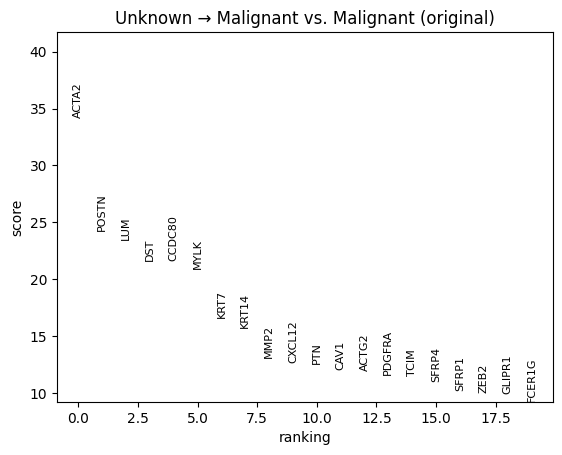

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Malignant_vs_Malignant.pdf


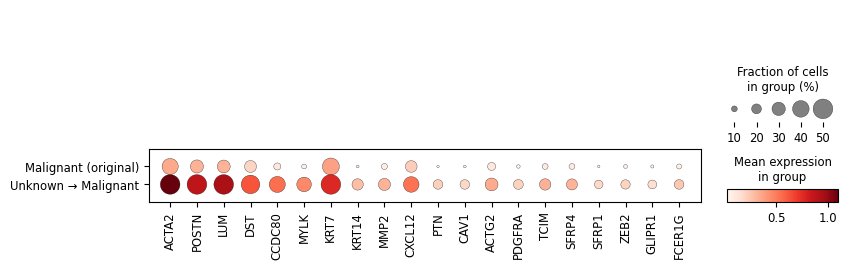

Saved: figures/Dotplot for Unknown_to_Malignant_vs_Malignant

Running DGE: Unknown_to_Normal_vs_Malignant (n=27233)
Saved: results/DGE/DGE_Unknown_to_Normal_vs_Malignant.csv


<Figure size 800x600 with 0 Axes>

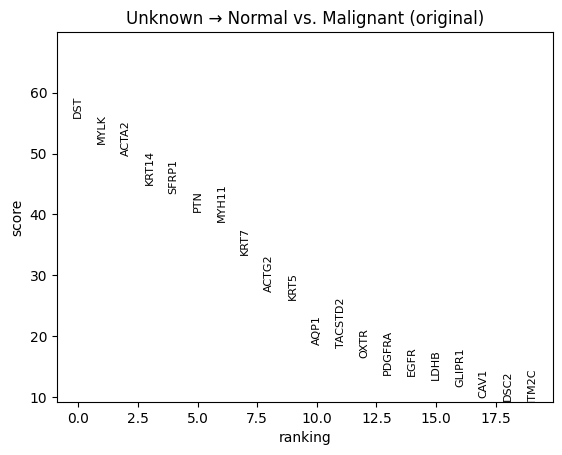

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Normal_vs_Malignant.pdf


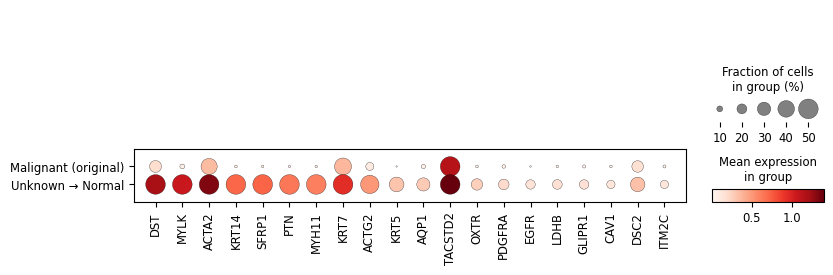

Saved: figures/Dotplot for Unknown_to_Normal_vs_Malignant

Running DGE: Unknown_to_Malignant_vs_Normal (n=27078)
Saved: results/DGE/DGE_Unknown_to_Malignant_vs_Normal.csv


<Figure size 800x600 with 0 Axes>

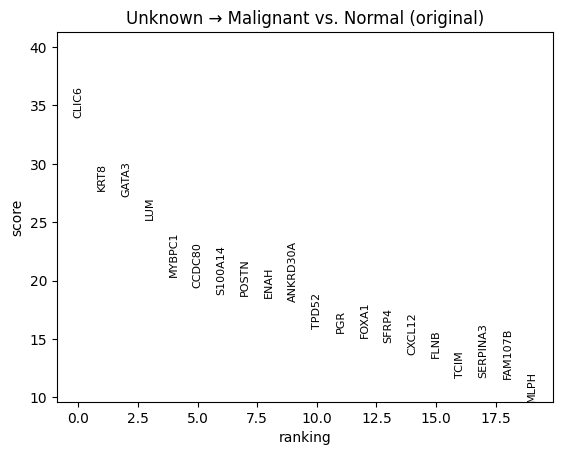

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Malignant_vs_Normal.pdf


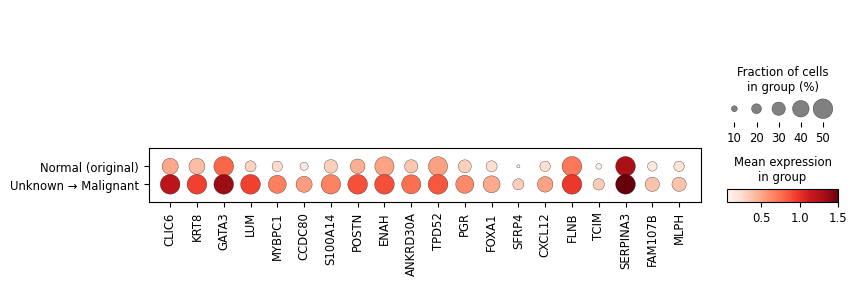

Saved: figures/Dotplot for Unknown_to_Malignant_vs_Normal

Running DGE: Unknown_to_Normal_vs_Normal (n=27233)
Saved: results/DGE/DGE_Unknown_to_Normal_vs_Normal.csv


<Figure size 800x600 with 0 Axes>

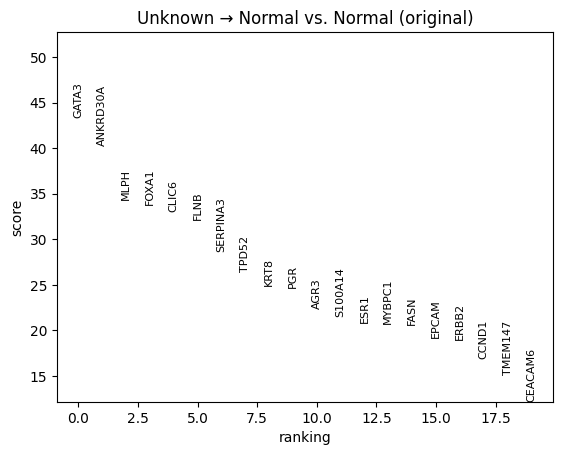

Saved: figures/DGE_rank_genes/RankGenes_Unknown_to_Normal_vs_Normal.pdf


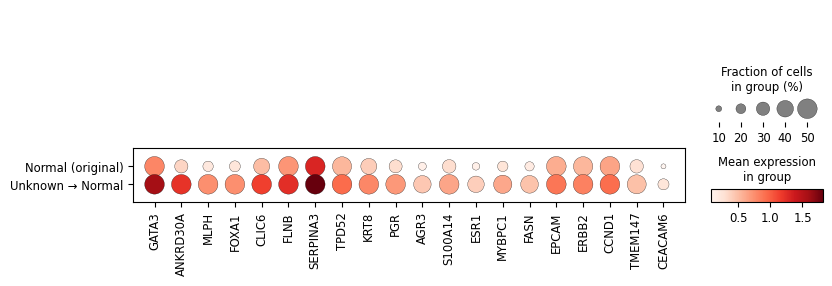

Saved: figures/Dotplot for Unknown_to_Normal_vs_Normal

Running DGE: Unknown_→_Malignant_vs_Unknown_→_Normal (n=4311)
Saved: results/DGE/DGE_Unknown_→_Malignant_vs_Unknown_→_Normal.csv


<Figure size 800x600 with 0 Axes>

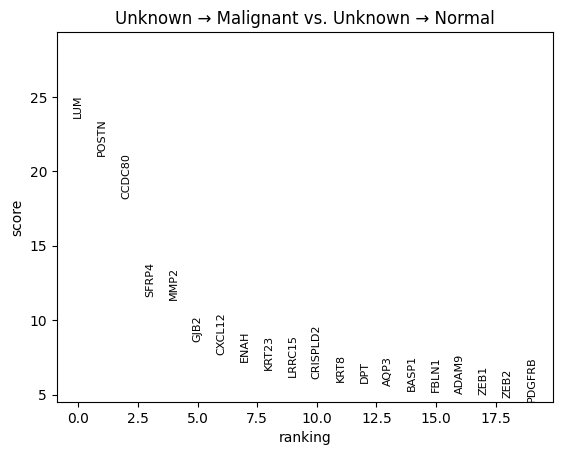

Saved: figures/DGE_rank_genes/RankGenes_Unknown_→_Malignant_vs_Unknown_→_Normal.pdf


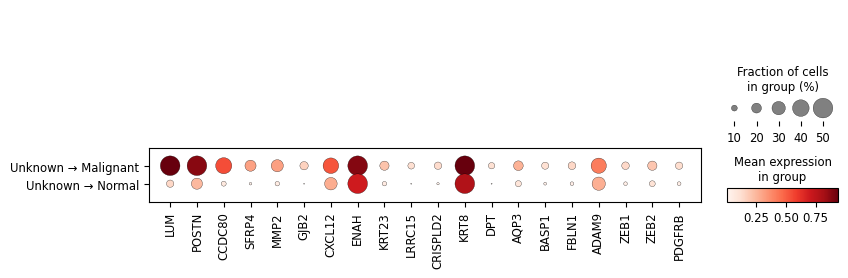

Saved: figures/Dotplot for Unknown_→_Malignant_vs_Unknown_→_Normal


In [71]:
def run_one_dge(sub_adata, contrast_name, ref, group, top_n_genes):
    print(f"\nRunning DGE: {contrast_name} (n={sub_adata.n_obs})")

    # DGE using Wilcoxon
    sc.tl.rank_genes_groups(
        sub_adata, 
        groupby='dge_group', 
        reference=ref, 
        method='wilcoxon')
    res = sub_adata.uns['rank_genes_groups']

    # Identify the group of interest (non-reference)
    other_group = [g for g in res['names'].dtype.names if g != ref][0]

    # Save CSV
    dge_df = pd.DataFrame({
        'gene': res['names'][other_group],
        'logfoldchange': res['logfoldchanges'][other_group],
        'pval': res['pvals'][other_group],
        'pval_adj': res['pvals_adj'][other_group]
    }).sort_values('pval_adj')
    dge_df.to_csv(f"results/DGE/DGE_{contrast_name}.csv", index=False)
    print(f"Saved: results/DGE/DGE_{contrast_name}.csv")

    # Rank genes plot
    plt.figure(figsize=(8,6))
    sc.pl.rank_genes_groups(
        sub_adata, 
        n_genes=top_n_genes, 
        sharey=False, 
        show=True, 
        use_raw=False, 
        title=contrast_name)
    plt.savefig(f"figures/DGE_rank_genes/RankGenes_{contrast_name}.pdf", dpi=300)
    plt.close()
    print(f"Saved: figures/DGE_rank_genes/RankGenes_{contrast_name}.pdf")

    # Dotplot of top genes (real mean values)
    top_genes = pd.Series(res['names'][other_group]).dropna().head(top_n_genes).tolist()
    if top_genes:
        sc.pl.dotplot(
            sub_adata,
            var_names=top_genes,
            groupby='dge_group',
            standard_scale=None,  
            dot_max=0.5,
            color_map='Reds',
            show=True,
            save=f"{contrast_name}.pdf")
        print(f"Saved: figures/Dotplot for {contrast_name}")

def run_dge_and_dotplots(
    adata, 
    reclassified_col, 
    celltype_col, 
    unknown_subgroups, 
    references, 
    top_n_genes=25):

    # --- Part 1: Unknown vs Malignant/Normal ---
    for ref in references:
        for unk_group in unknown_subgroups:
            contrast_name = f"{unk_group.replace(' ', '_').replace('→', 'to')}_vs_{ref}"
            cells_condition = (
                (adata.obs[reclassified_col] == unk_group) |
                (adata.obs[celltype_col] == ref))
            sub_adata = adata[cells_condition].copy()
            sub_adata.obs['dge_group'] = sub_adata.obs[reclassified_col].where(
                sub_adata.obs[reclassified_col] == unk_group,
                f"{ref} (original)")
            run_one_dge(sub_adata, contrast_name, f"{ref} (original)", unk_group, top_n_genes)

    # --- Part 2: Unknown→Malignant vs Unknown→Normal ---
    unk1, unk2 = "Unknown → Malignant", "Unknown → Normal"
    contrast_name = f"{unk1.replace(' ', '_')}_vs_{unk2.replace(' ', '_')}"
    cells_condition = (
        (adata.obs[reclassified_col] == unk1) |
        (adata.obs[reclassified_col] == unk2))
    sub_adata = adata[cells_condition].copy()
    sub_adata.obs['dge_group'] = sub_adata.obs[reclassified_col]
    run_one_dge(sub_adata, contrast_name, unk2, unk1, top_n_genes)

# Main parameters
reclassified_col = f'reclassified_cluster_{n_comp}'
celltype_col = 'cell_type_prediction'
unknown_subgroups = ['Unknown → Malignant', 'Unknown → Normal']
references = ['Malignant', 'Normal']

# Run all DGE analyses and dotplots
run_dge_and_dotplots(
    adata,
    reclassified_col,
    celltype_col,
    unknown_subgroups,
    references,
    top_n_genes=20)

## Average Gene Expression in the Target Cluster

This section computes the average gene expression for a specific target cluster (`Unknown → Malignant`) compared to all other cells.  

Steps performed:  
- Select the cells belonging to the target cluster and the rest.  
- Compute mean expression for each gene in the target and other cells.  
- Calculate the difference in expression between target and other cells.  
- Display the top genes with the highest differential expression.  
- Generate a dotplot for selected marker genes.  
- Print the mean expression of selected markers per cluster.  

This helps to highlight genes specifically enriched in the target cluster.

In [73]:
cluster_col = 'reclassified_cluster_4_scaled'
target_cluster = 'Unknown → Malignant'

# Select cells belonging to the target cluster
cells_target = adata.obs[adata.obs[cluster_col] == target_cluster].index
cells_other = adata.obs[adata.obs[cluster_col] != target_cluster].index

# Compute mean gene expression for target and other cells
mean_expr_target = adata[cells_target].X.mean(axis=0).A1  # .A1 converts sparse matrix to 1D array
mean_expr_other = adata[cells_other].X.mean(axis=0).A1

genes = adata.var_names

# Create DataFrame
df_means = pd.DataFrame({
    'gene': genes,
    'mean_expr_target': mean_expr_target,
    'mean_expr_other': mean_expr_other,
    'diff': mean_expr_target - mean_expr_other})

# Sort by decreasing difference
df_means_sorted = df_means.sort_values('diff', ascending=False)

print(df_means_sorted.head(4))

       gene  mean_expr_target  mean_expr_other      diff
159     LUM          0.940044         0.301796  0.638247
201   POSTN          0.875452         0.385857  0.489595
35   CCDC80          0.544045         0.129499  0.414546
76   CXCL12          0.527710         0.232229  0.295481


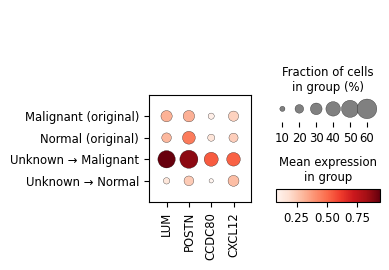

                                    LUM     POSTN    CCDC80    CXCL12
reclassified_cluster_4_scaled                                        
Malignant (original)           0.316959  0.320681  0.107428  0.224537
Normal (original)              0.300128  0.463494  0.156431  0.235525
Unknown → Malignant            0.940044  0.875453  0.544045  0.527710
Unknown → Normal               0.150756  0.246381  0.075067  0.281500


In [74]:
sc.pl.dotplot(
    adata,
    var_names=['LUM', 'POSTN', 'CCDC80', 'CXCL12'],
    groupby=reclassified_col,  
    color_map='Reds',
    show=True)

mean_expr = adata.to_df()[['LUM', 'POSTN', 'CCDC80', 'CXCL12']].join(
    adata.obs[reclassified_col]
).groupby(reclassified_col).mean()

print(mean_expr)

## Final Cell Classification

Aggregation of the reclassified clusters into the final categories: Malignant, Normal, and Unknown.

In [75]:
adata.obs['final_labels_scaled'] = adata.obs[reclassified_col].apply(
    lambda x: 'Malignant' if x in ['Malignant (original)', 'Unknown → Malignant'] 
             else 'Normal' if x in ['Normal (original)', 'Unknown → Normal'] 
             else 'Unknown' if x == 'Unknown (unchanged)' 
             else x)

print(adata.obs['final_labels_scaled'].value_counts())

final_labels_scaled
Normal       27233
Malignant    27078
Name: count, dtype: int64


## UMAP Visualization of Features

UMAP embeddings computed for both histological and molecular features, considering both scaled and unscaled versions.

In [76]:
def preprocess_and_umap(adata, rep_name, cluster_col, title):
    sc.pp.neighbors(adata, use_rep=rep_name)
    sc.tl.umap(adata)
    sc.pl.umap(
        adata, 
        color=cluster_col, 
        title=title, 
        palette="tab10", 
        legend_loc="right margin")

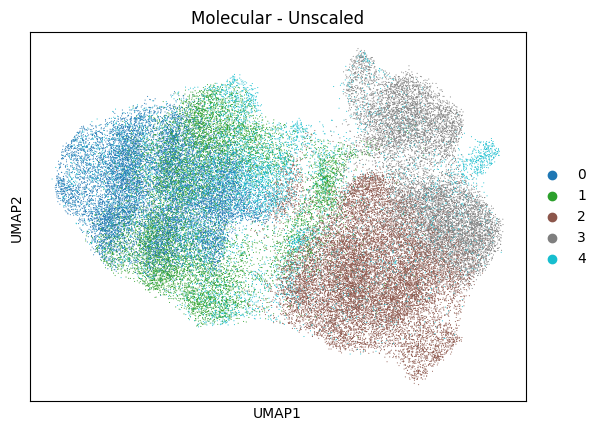

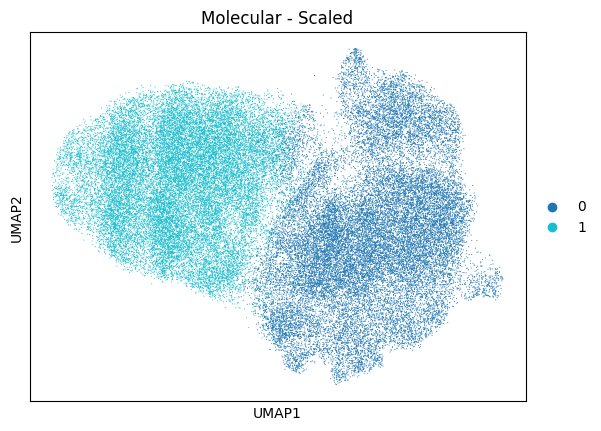

In [77]:
# Unscaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features",
    cluster_col="cluster_5_unscaled",
    title="Molecular - Unscaled")

# Scaled
preprocess_and_umap(
    adata_molecular_single_features_down,
    rep_name="molecular_single_features_scaled",
    cluster_col="cluster_2_scaled",
    title="Molecular - Scaled")

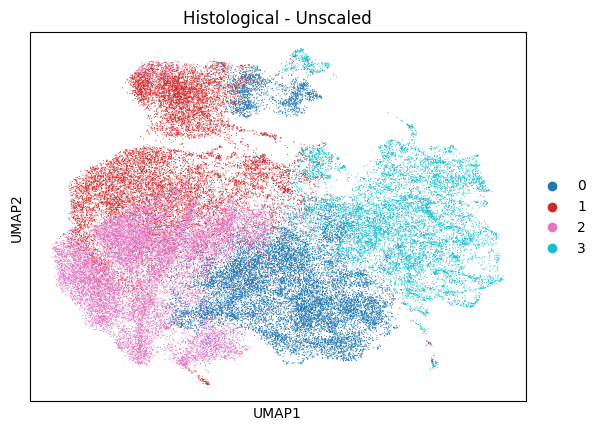

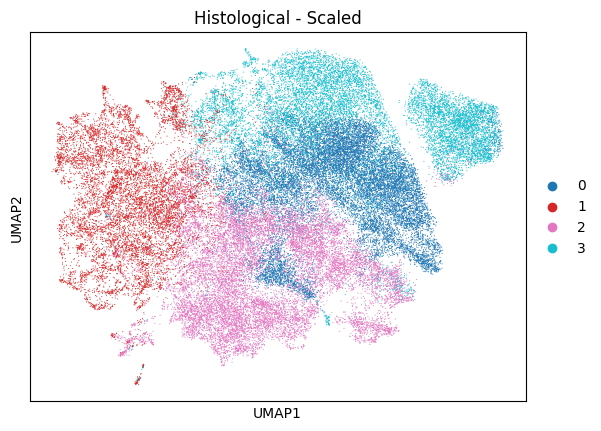

In [78]:
# Unscaled
preprocess_and_umap(
    adata_histological_single_features_down,
    rep_name="histological_single_features",
    cluster_col="cluster_4_unscaled",
    title="Histological - Unscaled")

# Scaled
preprocess_and_umap(
    adata_histological_single_features_down,
    rep_name="histological_single_features_scaled",
    cluster_col="cluster_4_scaled",
    title="Histological - Scaled")

## GMM Clustering on Single Features

Gaussian Mixture Model (GMM) clustering with k=2 applied to identify hidden clusters in both histological and molecular features.

In [108]:
def run_gmm_clustering_on_features(
    adata,
    feature_key: str,
    cluster_key: str = 'GMM_clusters',
    n_components: int = 2,
    random_state: int = 42,
    compute_umap: bool = True):

    # Extract features
    X = adata.obsm[feature_key]

    # Apply GMM
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    clusters = gmm.fit_predict(X)

    # Save clusters in obs
    adata.obs[cluster_key] = clusters.astype(str)  # salva come stringa per compatibilità grafici
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")

    # Compute neighbors + UMAP
    if compute_umap:
        sc.pp.neighbors(adata, use_rep=feature_key)
        sc.tl.umap(adata)

    print(f"GMM clustering with {n_components} clusters saved in adata.obs['{cluster_key}']")

In [109]:
# MOLECULAR SINGLE FEATURES DOWN SCALED
run_gmm_clustering_on_features(
    adata=adata_molecular_single_features_down,
    feature_key='molecular_single_features_scaled',
    cluster_key='GMM_clusters_scaled')

run_gmm_clustering_on_features(
    adata=adata_molecular_single_features_down,
    feature_key='molecular_single_features',
    cluster_key='GMM_clusters_unscaled')

# HISTOLOGICAL SINGLE FEATURES DOWN SCALED
run_gmm_clustering_on_features(
    adata=adata_histological_single_features_down,
    feature_key='histological_single_features_scaled',
    cluster_key='GMM_clusters_scaled')

# HISTOLOGICAL SINGLE FEATURES DOWN 
run_gmm_clustering_on_features(
    adata=adata_histological_single_features_down,
    feature_key='histological_single_features',
    cluster_key='GMM_clusters_unscaled')

GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_scaled']
GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_unscaled']
GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_scaled']
GMM clustering with 2 clusters saved in adata.obs['GMM_clusters_unscaled']


## Comparison of GMM Clusters vs Cell Type Predictions

Side-by-side UMAP visualization:  
- Left: clusters identified by Gaussian Mixture Model (GMM)  
- Right: original cell type predictions

In [81]:
def plot_umap_gmm_vs_celltype(
    adata,
    cluster_key='GMM_clusters',
    cluster_palette=['blue', 'red'],
    celltype_palette={'Normal': '#009E73', 'Malignant': 'red', 'Unknown': '#4682B4'},
    title_left='GMM Clustering (k=2)',
    title_right='Cell Type Prediction',
    figsize=(12, 5),
    save_path=None):

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # GMM Clustering
    sc.pl.umap(
        adata,
        color=cluster_key,
        palette=cluster_palette,
        title=title_left,
        ax=axes[0],
        show=False    )

    # Cell Type Prediction
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette=celltype_palette,
        title=title_right,
        ax=axes[1],
        show=False    )

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

## Analysis of GMM Clusters in Unknown Cells

- Visualize two UMAPs side by side:  
  - Left: GMM clusters with Unknown cells highlighted  
  - Right: only Unknown cells shown in red  
- Count how many Unknown cells are classified as Malignant or Normal  
- Display results with a bar plot showing the classification of Unknown cells by GMM clusters

In [87]:
def plot_gmm_vs_unknown_highlight(
    adata,
    cluster_key: str = 'GMM_clusters',
    title_left: str = 'GMM clustering of Unknown cells (highlighted)',
    title_right: str = 'Cell Type Prediction (highlight Unknown)',
    save_path: str = None):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Masks
    mask_known = adata.obs['cell_type_prediction'].isin(['Normal', 'Malignant'])
    mask_unknown = adata.obs['cell_type_prediction'] == 'Unknown'

    # Dynamic palette for clusters
    if str(adata.obs[cluster_key].dtype) == "category":
        cluster_categories = adata.obs[cluster_key].cat.categories
    else:
        cluster_categories = pd.unique(adata.obs[cluster_key])

    # Build color dictionary depending on type (str or int)
    if all(isinstance(c, str) for c in cluster_categories):
        cluster_palette = {'0': '#D94F4F', '1': '#009E73'}
    else:
        cluster_palette = {0: '#D94F4F', 1: '#009E73'}

    # --- Left plot: GMM clustering with Unknown highlighted ---
    sc.pl.umap(
        adata[mask_known],
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray'},
        size=10,
        alpha=0.3,
        ax=axes[0],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color=cluster_key,
        palette=cluster_palette,
        size=10,
        alpha=0.6,
        ax=axes[0],
        show=False,
        legend_loc='right')
    axes[0].set_title(title_left)

    # --- Right plot: Unknown highlighted ---
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray', 'Unknown': 'lightgray'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color='cell_type_prediction',
        palette={'Unknown': 'blue'},
        size=10,
        alpha=0.6,
        ax=axes[1],
        show=False)
    axes[1].set_title(title_right)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

In [88]:
def plot_gmm_classification_of_unknowns(
    adata,
    cluster_col: str,
    cell_type_col: str = 'cell_type_prediction',
    unknown_label: str = 'Unknown',
    cluster_label_map: dict = None,
    palette: list = ['#009E73', '#D94F4F'],
    title: str = 'GMM Classification of Unknown Cell Types',
    save_path: str = None):
   
    unknown_cells = adata[adata.obs[cell_type_col] == unknown_label]

    cluster_data = unknown_cells.obs[cluster_col].copy()
    try:
        cluster_data = cluster_data.astype(int)
    except (ValueError, TypeError):
        pass

    if cluster_label_map is not None:
        cluster_data_mapped = cluster_data.map(cluster_label_map)
    else:
        cluster_data_mapped = cluster_data

    df_plot = pd.DataFrame({'gmm_cluster_label': cluster_data_mapped})

    desired_order = ['Malignant', 'Normal']
    desired_palette = {'Malignant': '#D94F4F', 'Normal': '#009E73'}

    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=df_plot, x='gmm_cluster_label',
                       order=desired_order, palette=desired_palette)

    plt.ylabel('Number of Unknown Cells')
    plt.title(title)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 1,
                int(height), ha="center", fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()

cell_type_prediction  Malignant  Normal  Unknown
GMM_clusters_scaled                             
0                         24557     250     1370
1                           443   24750     2941


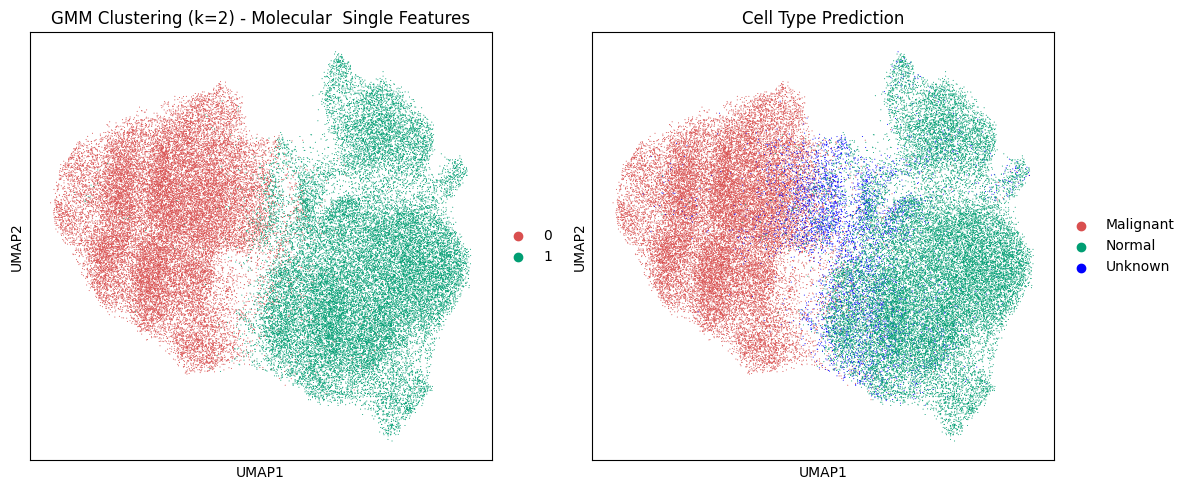

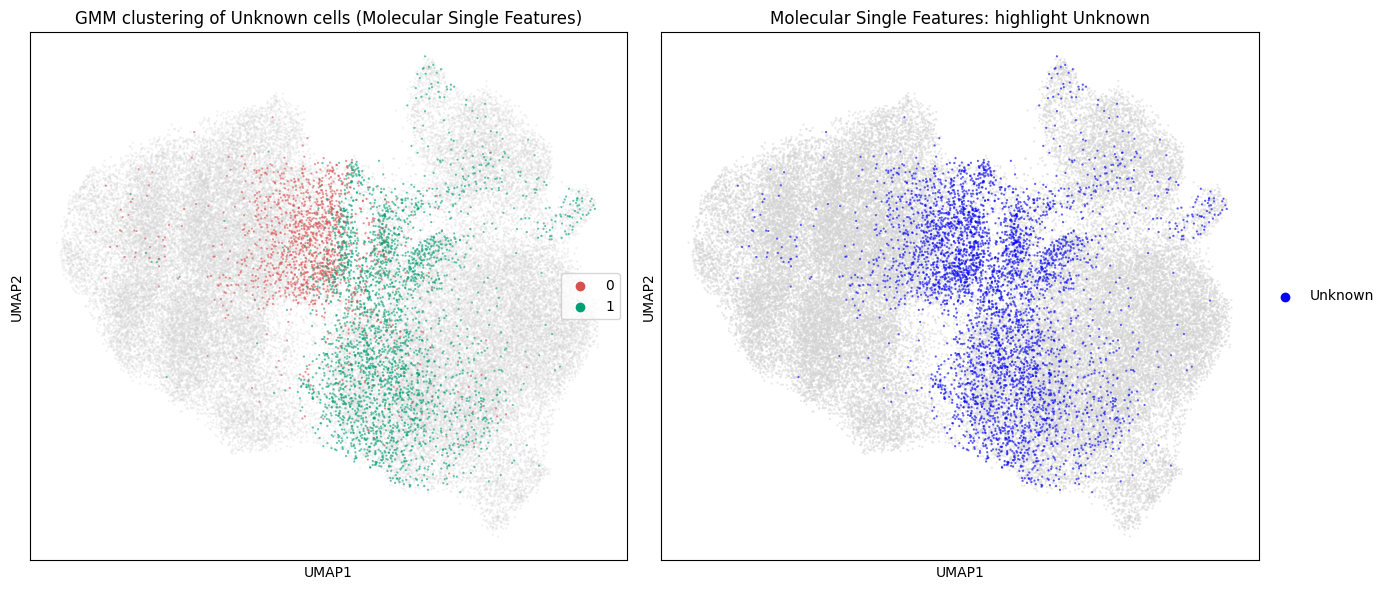

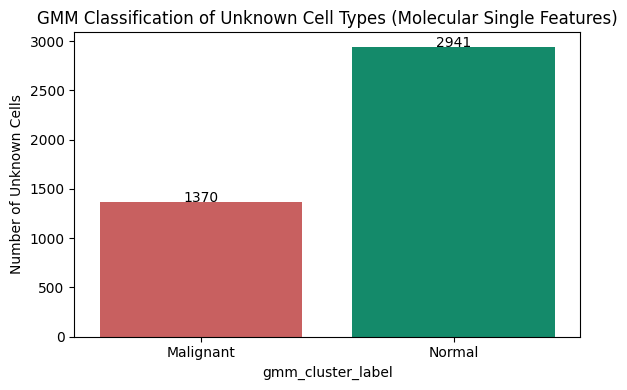

In [90]:
# Visualization of Molecular Single Features Downsampling
adata_molecular_single_features_down.obs["GMM_clusters_scaled"].value_counts()
print(pd.crosstab(
    adata_molecular_single_features_down.obs["GMM_clusters_scaled"],
    adata_molecular_single_features_down.obs["cell_type_prediction"]))

plot_umap_gmm_vs_celltype(
    adata=adata_molecular_single_features_down,
    cluster_key='GMM_clusters_scaled',
    cluster_palette=['#D94F4F', '#009E73'],
    celltype_palette={'Normal': '#009E73', 'Malignant': '#D94F4F', 'Unknown': 'blue'},
    title_left='GMM Clustering (k=2) - Molecular  Single Features',
    title_right='Cell Type Prediction',
    save_path='figures/umap_gmm_vs_celltype_molecular_single_features_down_scaled.png')

plot_gmm_vs_unknown_highlight(
    adata=adata_molecular_single_features_down,
    cluster_key='GMM_clusters_scaled',
    title_left='GMM clustering of Unknown cells (Molecular Single Features)',
    title_right='Molecular Single Features: highlight Unknown',
    save_path='figures/umap_molecular_single_features_down_scaled_gmm_vs_unknown.png')

plot_gmm_classification_of_unknowns(
    adata=adata_molecular_single_features_down,
    cluster_col='GMM_clusters_scaled',
    cell_type_col='cell_type_prediction',
    unknown_label='Unknown',
    cluster_label_map={0: 'Malignant', 1: 'Normal'},
    palette=['#D94F4F', '#009E73'],
    title='GMM Classification of Unknown Cell Types (Molecular Single Features)',
    save_path='figures/barplot_gmm_molecular_single_features_down_scaled_unknowns.png')

cell_type_prediction  Malignant  Normal  Unknown
GMM_clusters_scaled                             
0                         21257    3043     1733
1                          3743   21957     2578


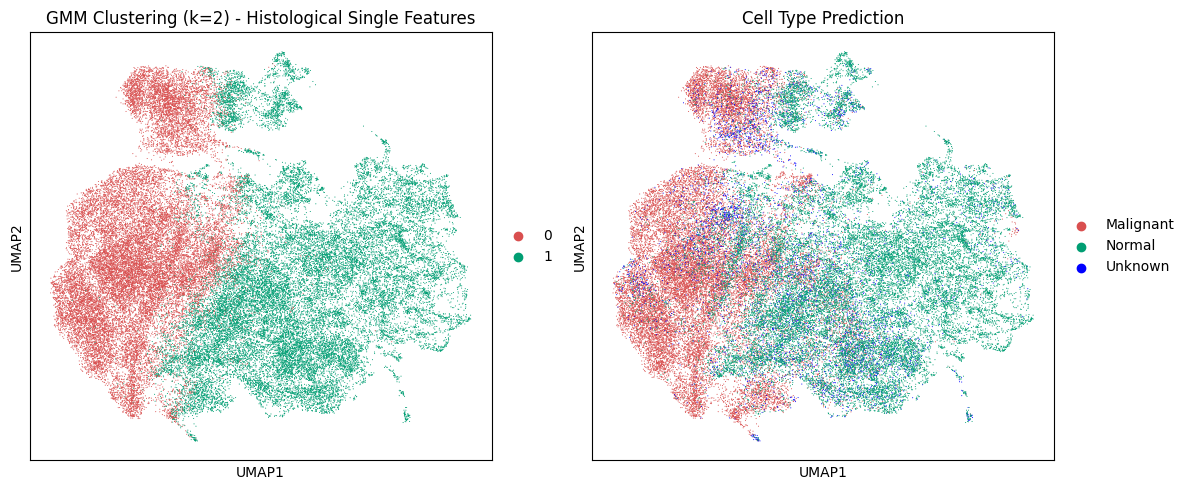

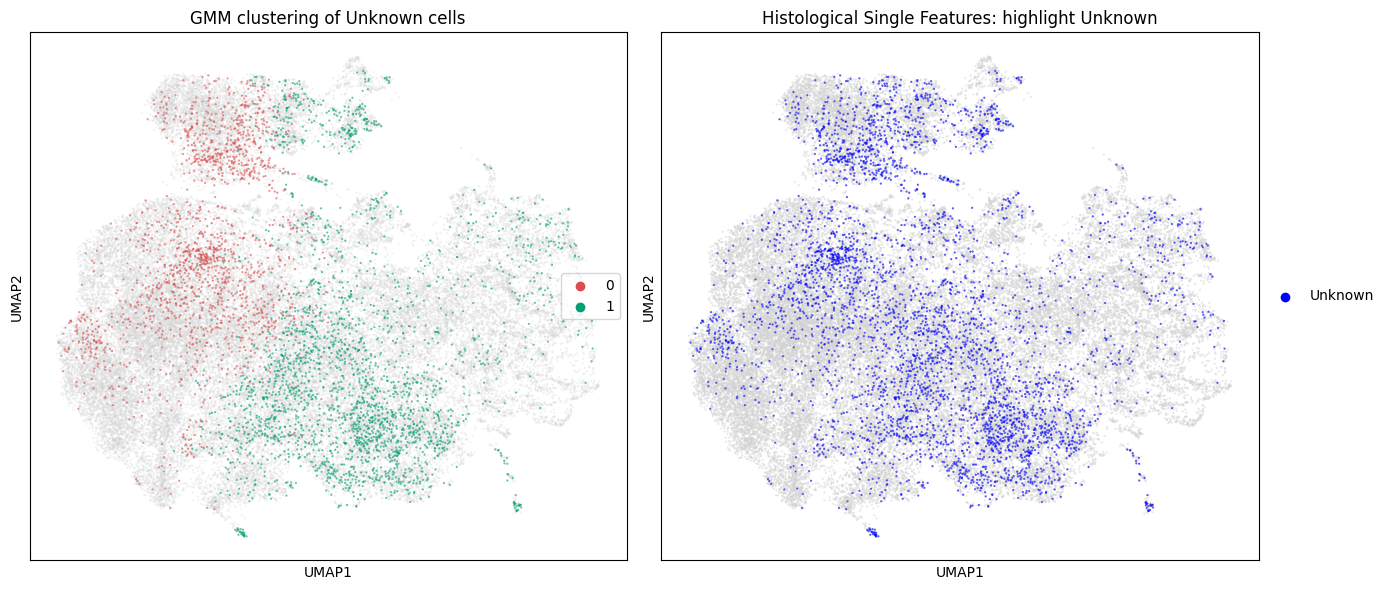

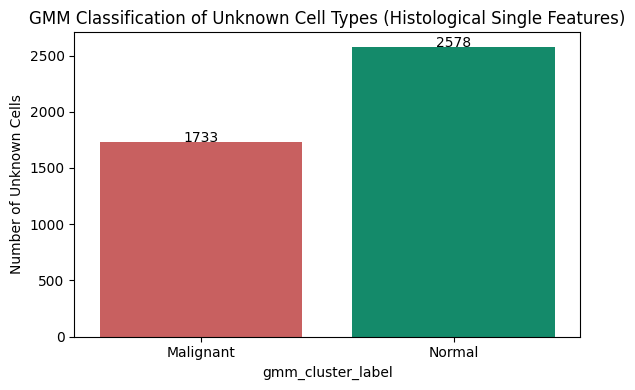

In [92]:
# Visualization of Histological Single Features Downsampling
adata_histological_single_features_down.obs["GMM_clusters_scaled"].value_counts()
print(pd.crosstab(
    adata_histological_single_features_down.obs["GMM_clusters_scaled"],
    adata_histological_single_features_down.obs["cell_type_prediction"]))

plot_umap_gmm_vs_celltype(
    adata=adata_histological_single_features_down,
    cluster_key='GMM_clusters_scaled',
    cluster_palette=['#D94F4F', '#009E73'],
    celltype_palette={'Normal': '#009E73', 'Malignant': '#D94F4F', 'Unknown': 'blue'},
    title_left='GMM Clustering (k=2) - Histological Single Features',
    title_right='Cell Type Prediction',
    save_path='figures/umap_gmm_vs_celltype_histological_single_features_down_scaled.png')

plot_gmm_vs_unknown_highlight(
    adata=adata_histological_single_features_down,
    cluster_key='GMM_clusters_scaled',
    title_left='GMM clustering of Unknown cells',
    title_right='Histological Single Features: highlight Unknown',
    save_path='figures/umap_histological_single_features_down_scaled_gmm_vs_unknown.png')

plot_gmm_classification_of_unknowns(
    adata=adata_histological_single_features_down,
    cluster_col='GMM_clusters_scaled',
    cell_type_col='cell_type_prediction',
    unknown_label='Unknown',
    cluster_label_map={0: 'Malignant', 1: 'Normal'},
    palette=['#D94F4F', '#009E73'],
    title='GMM Classification of Unknown Cell Types (Histological Single Features)',
    save_path='figures/barplot_gmm_histological_single_features_down_scaled_unknowns.png')

## Adjusted Rand Index (ARI) between GMM Clusters and True Labels

- Compute ARI for both molecular and histological features  
- Compare GMM-derived clusters with true cell type labels to assess clustering accuracy

In [96]:
# Extract predicted labels from GMM clusters
pred_labels = adata_molecular_single_features_down.obs["GMM_clusters_scaled"].astype(int)

# Extract true labels (from 'cell_type_prediction')
true_labels = adata_molecular_single_features_down.obs["cell_type_prediction"]

# If 'cell_type_prediction' is a string, convert it to numbers using a map
label_map = {'Malignant': 0, 'Normal': 1, 'Unknown': 2}
true_labels_num = true_labels.map(label_map)

# Compute ARI
ari_score = adjusted_rand_score(true_labels_num, pred_labels)
print(f"Adjusted Rand Index (ARI) between GMM clusters and true labels: {ari_score:.4f}")

Adjusted Rand Index (ARI) between GMM clusters and true labels: 0.8017


In [97]:
# Extract predicted labels from GMM clusters
pred_labels = adata_histological_single_features_down.obs["GMM_clusters_scaled"].astype(int)

# Extract true labels (from 'cell_type_prediction')
true_labels = adata_histological_single_features_down.obs["cell_type_prediction"]

# If 'cell_type_prediction' is a string, convert it to numbers using a map
label_map = {'Malignant': 0, 'Normal': 1, 'Unknown': 2}
true_labels_num = true_labels.map(label_map)

# Compute ARI
ari_score = adjusted_rand_score(true_labels_num, pred_labels)
print(f"Adjusted Rand Index (ARI) between GMM clusters and true labels: {ari_score:.4f}")

Adjusted Rand Index (ARI) between GMM clusters and true labels: 0.4494


## Mapping of Histological Clusters to Final Labels

- Numeric histological clusters are mapped to biologically meaningful categories

In [107]:
# Define string → label mapping
cluster_map = {
    '0': 'Malignant',
    '1': 'Normal'}

# Create a new column with the final labels
adata_histological_single_features_down.obs['final_GMM_clusters_scaled'] = (
    adata_histological_single_features_down.obs['GMM_clusters_scaled'].map(cluster_map))

# Check the result
print(adata_histological_single_features_down.obs['final_GMM_clusters_scaled'].value_counts())

final_GMM_clusters_scaled
Normal       28278
Malignant    26033
Name: count, dtype: int64


## Cluster Evaluation and Confusion Matrix Heatmap

- Compute crosstab, accuracy, Cohen's Kappa, and full classification report.  
- Visualize confusion matrix for both scaled and unscaled features.

In [101]:
def evaluate_gmm_vs_labels(adata, gmm_col, label_col):
    # Ensure no NaN values
    valid = adata.obs.dropna(subset=[gmm_col, label_col]).copy()
    
    print(f"\n=== Analysis: {gmm_col} vs {label_col}")
    
    # Crosstab
    ct = pd.crosstab(
        valid[gmm_col],
        valid[label_col],
        rownames=[gmm_col],
        colnames=[label_col])
    print("\nCrosstab:")
    print(ct)
    
    # Accuracy
    y_true = valid[label_col]
    y_pred = valid[gmm_col]
    accuracy = accuracy_score(y_true, y_pred)
    print("\nAccuracy:", accuracy)
    
    # Cohen's Kappa
    print("Cohen's Kappa:", cohen_kappa_score(y_true, y_pred))
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Execution for scaled molecular features
evaluate_gmm_vs_labels(
    adata_molecular_single_features_down,
    gmm_col='final_GMM_clusters_scaled',
    label_col='final_labels_scaled')

# Execution for unscaled molecular features
evaluate_gmm_vs_labels(
    adata_molecular_single_features_down,
    gmm_col='final_GMM_clusters_unscaled',
    label_col='final_labels_unscaled')


=== Analysis: final_GMM_clusters_scaled vs final_labels_scaled

Crosstab:
final_labels_scaled        Malignant  Normal
final_GMM_clusters_scaled                   
Malignant                      25924     253
Normal                           443   27691

Accuracy: 0.98718491649942
Cohen's Kappa: 0.9743429886430147

Classification Report:
              precision    recall  f1-score   support

   Malignant       0.99      0.98      0.99     26367
      Normal       0.98      0.99      0.99     27944

    accuracy                           0.99     54311
   macro avg       0.99      0.99      0.99     54311
weighted avg       0.99      0.99      0.99     54311


=== Analysis: final_GMM_clusters_unscaled vs final_labels_unscaled

Crosstab:
final_labels_unscaled        Malignant  Normal
final_GMM_clusters_unscaled                   
Malignant                        25690     324
Normal                            1797   26500

Accuracy: 0.9609471377805601
Cohen's Kappa: 0.9219343349117826



## Confusion Matrix Heatmaps

Display heatmaps of the confusion matrices for both scaled and unscaled features.

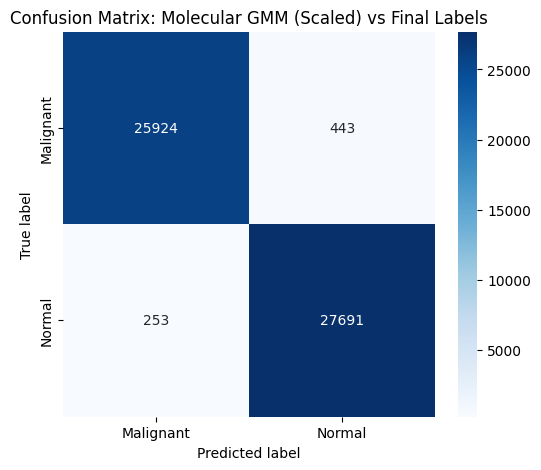

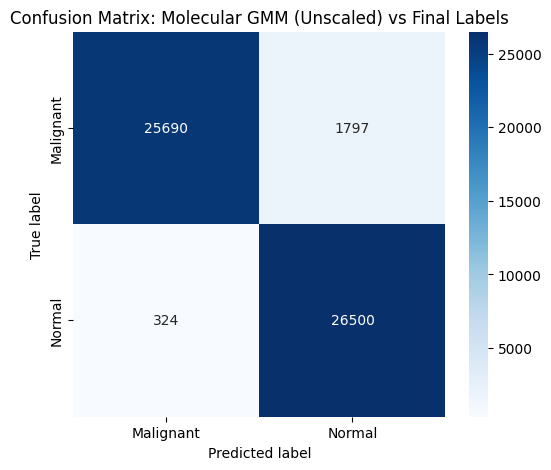

In [99]:
def plot_confusion_heatmap(y_true, y_pred, title):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['Malignant', 'Normal'])
    cm_df = pd.DataFrame(cm, index=['Malignant', 'Normal'], columns=['Malignant', 'Normal'])
    
    # Plot
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# --- Heatmap for scaled features ---
plot_confusion_heatmap(
    adata_molecular_single_features_down.obs['final_labels_scaled'],
    adata_molecular_single_features_down.obs['final_GMM_clusters_scaled'],
    'Confusion Matrix: Molecular GMM (Scaled) vs Final Labels')

# --- Heatmap for unscaled features ---
plot_confusion_heatmap(
    adata_molecular_single_features_down.obs['final_labels_unscaled'],
    adata_molecular_single_features_down.obs['final_GMM_clusters_unscaled'],
    'Confusion Matrix: Molecular GMM (Unscaled) vs Final Labels')

## Comparison of Molecular vs Histological GMM Clustering

This section compares the GMM clustering results between molecular and histological single features (scaled and downsampled).  
A confusion matrix is computed for the aligned cells to assess agreement between the two clustering approaches.

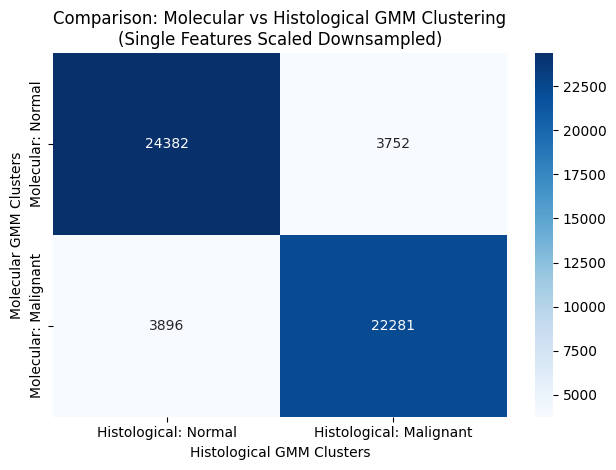

In [55]:
# Find the names of the common cells
common_cells = adata_molecular_single_features_down.obs_names.intersection(
    adata_histological_single_features_down.obs_names)

# Filter both datasets
mol_aligned = adata_molecular_single_features_down[common_cells].copy()
hist_aligned = adata_histological_single_features_down[common_cells].copy()

# Verify that the cell names are aligned
assert all(mol_aligned.obs_names == hist_aligned.obs_names)

# Extract aligned cluster labels and map to 'Normal' / 'Malignant'
cluster_label_map = {'0': 'Malignant', '1': 'Normal'}

gmm_mol = mol_aligned.obs["GMM_clusters"].map(cluster_label_map)
gmm_hist = hist_aligned.obs["GMM_clusters"].map(cluster_label_map)

# Confusion matrix
conf_mat = confusion_matrix(
    gmm_mol,
    gmm_hist,
    labels=['Normal', 'Malignant'])

# Visualize
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Histological: Normal', 'Histological: Malignant'],
            yticklabels=['Molecular: Normal', 'Molecular: Malignant'])
plt.xlabel('Histological GMM Clusters')
plt.ylabel('Molecular GMM Clusters')
plt.title('Comparison: Molecular vs Histological GMM Clustering\n(Single Features Scaled Downsampled)')
plt.tight_layout()
plt.show()

## Confusion Matrix for "Unknown" Cells: Molecular vs Histological GMM Classification

Analyze cells labeled as "Unknown" in both datasets.

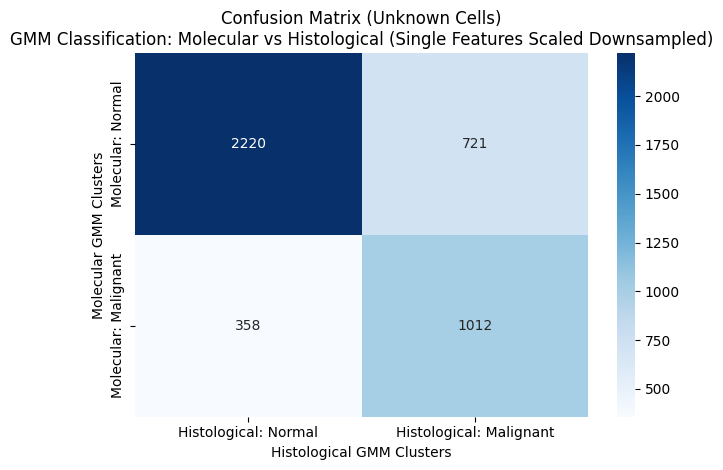

In [56]:
unknown_mol = adata_molecular_single_features_down.obs_names[
    adata_molecular_single_features_down.obs['cell_type_prediction'] == 'Unknown']

unknown_hist = adata_histological_single_features_down.obs_names[
    adata_histological_single_features_down.obs['cell_type_prediction'] == 'Unknown']

# Intersection: only Unknown cells present in both datasets
common_unknown = unknown_mol.intersection(unknown_hist)

mol_unknown = adata_molecular_single_features_down[common_unknown].copy()
hist_unknown = adata_histological_single_features_down[common_unknown].copy()

# Verify perfect alignment
assert all(mol_unknown.obs_names == hist_unknown.obs_names)

cluster_label_map_mol = {'0': 'Malignant', '1': 'Normal'}

gmm_mol = mol_unknown.obs["GMM_clusters"].map(cluster_label_map_mol)
gmm_hist = hist_unknown.obs["GMM_clusters"].map(cluster_label_map_mol)

conf_mat = confusion_matrix(
    gmm_mol,
    gmm_hist,
    labels=['Normal', 'Malignant'])

sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Histological: Normal', 'Histological: Malignant'],
    yticklabels=['Molecular: Normal', 'Molecular: Malignant'])

plt.title('Confusion Matrix (Unknown Cells)\nGMM Classification: Molecular vs Histological (Single Features Scaled Downsampled)')
plt.xlabel('Histological GMM Clusters')
plt.ylabel('Molecular GMM Clusters')
plt.tight_layout()
plt.show()